In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
#os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".25"

import torch
torch.multiprocessing.set_start_method('spawn')

In [3]:
# Add parent folder to path (to run this file from subdirectories)
(parent_folder_path, current_dir) = os.path.split(os.path.abspath(''))
sys.path.append(parent_folder_path)

# add git submodule to path to allow imports to work
submodule_name = 'AlphaTrade'
(parent_folder_path, current_dir) = os.path.split(os.path.abspath(''))
sys.path.append(os.path.join(parent_folder_path, submodule_name))

from gymnax_exchange.jaxob.jorderbook import OrderBook
import gymnax_exchange.jaxob.JaxOrderbook as job

In [4]:
from argparse import Namespace
from glob import glob
import numpy as onp
import pandas as pd
from functools import partial
from typing import Union, Optional
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
from jax.nn import one_hot
from jax import random
from jax.scipy.linalg import block_diag
from flax import jax_utils
from flax.training import checkpoints
import orbax

#from lob.lob_seq_model import BatchLobPredModel
from lob.train_helpers import create_train_state, eval_step, prep_batch, cross_entropy_loss, compute_accuracy
from s5.ssm import init_S5SSM
from s5.ssm_init import make_DPLR_HiPPO
from s5.dataloading import make_data_loader
from lob_seq_model import LobPredModel
from encoding import Vocab, Message_Tokenizer
from lobster_dataloader import LOBSTER_Dataset, LOBSTER_Subset, LOBSTER_Sampler, LOBSTER

import preproc
import inference
import validation_helpers as valh
from lob.init_train import init_train_state, load_checkpoint, load_args_from_checkpoint
import lob.encoding as encoding

# necessary for flax checkpoints to be loaded in jupyter notebook
import nest_asyncio
nest_asyncio.apply()

## Model

In [5]:
n_messages = 500
v = Vocab()
n_classes = len(v)
seq_len = n_messages * Message_Tokenizer.MSG_LEN
book_dim = 501 #b_enc.shape[1]
book_seq_len = n_messages

rng = jax.random.PRNGKey(42)
rng, rng_ = jax.random.split(rng)

In [6]:
# ckpt_path = '../checkpoints/brisk-surf-147_yc8wpyi3/'
# ckpt_path = '../checkpoints/scarlet-voice-168_iqq80fnp/'
# ckpt_path = '../checkpoints/ancient-dawn-506_ykmjf41l/'  # FLAIR Node trained on 0.5 years of GOOG
# ckpt_path = '../checkpoints/bumbling-sun-108_idstu91x/'  # new encoding
# ckpt_path = '../checkpoints/rare-field-129_i52a4aga/'  # new encoding, 0.5 years of GOOG
# ckpt_path = '../checkpoints/autumn-elevator-133_n7oa0i2g/'  # fast encoding
ckpt_path = '../checkpoints/swept-river-135_3kcdrclh/' # after rounding bug fixes

In [7]:
args = load_args_from_checkpoint(ckpt_path)
args

Namespace(C_init='trunc_standard_normal', USE_WANDB=True, activation_fn='half_glu1', batchnorm=True, bidirectional=True, blocks=8, bn_momentum=0.95, book_depth=500, book_transform=True, bsz=10, clip_eigs=True, conj_sym=True, cosine_anneal=True, d_model=128, dataset='lobster-prediction', dir_name='./data/fast_encoding', discretization='zoh', dt_global=False, dt_max=0.1, dt_min=0.001, early_stop_patience=1000, epochs=100, jax_seed=42, lr_factor=1.0, lr_min=0, lr_patience=1000000, masking='causal', mode='pool', msg_seq_len=500, n_book_post_layers=1, n_book_pre_layers=1, n_data_workers=2, n_layers=6, n_message_layers=2, num_devices=1, opt_config='standard', p_dropout=0.0, prenorm=True, reduce_factor=1.0, restore=None, restore_step=None, ssm_lr_base=0.0005, ssm_size_base=256, use_book_data=True, use_simple_book=False, wandb_entity='peer-nagy', wandb_project='LOBS5', warmup_end=1, weight_decay=0.05)

In [8]:
# scale down to single GPU, single sample inference
args.bsz = 1
args.num_devices = 1

batchnorm = args.batchnorm

In [9]:
# load train state from disk

new_train_state, model_cls = init_train_state(
    args,
    n_classes=n_classes,
    seq_len=seq_len,
    book_dim=book_dim,
    book_seq_len=book_seq_len,
)

ckpt = load_checkpoint(
    new_train_state,
    ckpt_path,
    args.__dict__)
par_state = ckpt['model']

configuring standard optimization setup
[*] Trainable Parameters: 6334776


In [10]:
# deduplicate params (they get saved per gpu in training)
state = par_state.replace(
    params=jax.tree_map(lambda x: x[0], par_state.params),
    batch_stats=jax.tree_map(lambda x: x[0], par_state.batch_stats),
)

In [11]:
model = model_cls(training=False, step_rescale=1.0)

### Forecasting

In [6]:
import lob.evaluation as eval
from lob.preproc import transform_L2_state

In [7]:
n_gen_msgs = 100  #500 # how many messages to generate into the future
n_messages = 500
n_eval_messages = 100  # how many to load from dataset 
eval_seq_len = n_eval_messages * Message_Tokenizer.MSG_LEN

data_levels = 10
sim_book_levels = 20 # 10  # order book simulator levels
sim_queue_len = 100  # per price in sim, how many orders in queue

n_vol_series = 500  # how many book volume series model uses as input

In [11]:
dataset_obj = LOBSTER(
    'lobster',
    # data_dir='/nfs/home/peern/LOBS5/data/new_enc/',
    data_dir='/nfs/home/peern/LOBS5/data/fast_encoding/',
    # use dummy mask function to get entire sequence
    mask_fn=LOBSTER_Dataset.causal_mask,#lambda X, rng: (X, jnp.array(0)),
    use_book_data=True,
    # book_transform=True,  # transform book to image
    use_simple_book=True,  # return (p,v) book and we'll do transorm to volume image later
    msg_seq_len=n_messages + n_eval_messages,
    return_raw_msgs=True,
    #raw_data_dir='/nfs/home/peern/LOBS5/data/raw/',
    n_cache_files=100,  # keep high enough to fit all files in memory
)
dataset_obj.setup()

ds = dataset_obj.dataset_test

In [54]:
from lob.dataloading import create_lobster_prediction_dataset

(lobster_dataset, trainloader, valloader, testloader, aux_dataloaders, 
        n_classes, seq_len, in_dim, book_seq_len, book_dim, train_size) = \
        create_lobster_prediction_dataset(
            '../data/fast_encoding',
            seed=42,
            mask_fn=LOBSTER_Dataset.causal_mask,
            msg_seq_len=500,
            bsz=10,
            use_book_data=True,
            use_simple_book=False,
            book_transform=True,
            n_data_workers=0,
        )

[*] Generating LOBSTER Prediction Dataset from ../data/fast_encoding
Using mask function: <function LOBSTER_Dataset.causal_mask at 0x7f7b307ab8b0>


In [45]:
a = jnp.arange(44).reshape(2,22)
a

Array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21],
       [22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
        38, 39, 40, 41, 42, 43]], dtype=int32)

In [48]:
jnp.tile(a, (1,3,1)).shape

(1, 6, 22)

In [52]:
jnp.expand_dims(a,1).shape

(2, 1, 22)

In [53]:
jnp.repeat(jnp.expand_dims(a,1), 3, axis=1)#.shape

Array([[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
         16, 17, 18, 19, 20, 21],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
         16, 17, 18, 19, 20, 21],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
         16, 17, 18, 19, 20, 21]],

       [[22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
         38, 39, 40, 41, 42, 43],
        [22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
         38, 39, 40, 41, 42, 43],
        [22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
         38, 39, 40, 41, 42, 43]]], dtype=int32)

In [58]:
for batch_idx, batch in enumerate(tqdm(trainloader)):
    print('len(batch)', len(batch))
    print(batch[2])
    batch[2]['msk_pos']
    inputs, labels, integration_times = prep_batch(batch, seq_len, in_dim, 1)
    print()
    print('labels', labels)
    print(inputs[0].shape)
    break

  0%|          | 0/2828 [00:00<?, ?it/s]

len(batch) 3
{'msk_pos': Array([17, 15, 20,  4,  0,  2,  5, 14,  0, 16], dtype=int32), 'book_data': Array([[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [-1.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       ...,

       [[ 0.,  0.,  0., ...,  0.

In [26]:
# 6 el tuple
ds[0][1]

6

In [15]:
ds.message_files

['/nfs/home/peern/LOBS5/data/fast_encoding/GOOG_2023-01-31_34200000_57600000_message_10_proc.npy']

In [16]:
from line_profiler import LineProfiler

In [17]:
import chex
chex.clear_trace_counter()

In [18]:
import logging
# logging.basicConfig(filename='ar_debug.log', level=logging.DEBUG)
fhandler = logging.FileHandler(filename='ar_debug.log', mode='w')
logger = logging.getLogger()
if (logger.hasHandlers()):
    logger.handlers.clear()
logger.addHandler(fhandler)
#logger.setLevel(logging.DEBUG)
logger.setLevel(logging.WARNING)

In [20]:
#%%prun -s cumulative
# profile function calls (not line by line)

rng = jax.random.PRNGKey(42)
rng, rng_ = jax.random.split(rng)

lp = LineProfiler()
lp.add_function(inference.get_sim_msg)   # add additional function to profile
inference_generate_lp = lp(inference.generate)

rets_gen = []
rets_eval = []
# squared errors of n-step forward return predictions
mid_ret_errs = []
# squared errors of returns using constant mid-price prediction
mid_ret_errs_const = []
# mean abs losses of book levels
book_losses_l1 = []
# benchmark: mean abs losses of book levels (constant prediction)
book_losses_l1_const = []
# wasserstein distance of book levels
book_losses_wass = []
book_losses_wass_const = []
# how many messages had to be discarded
num_errors = []
event_types_gen = []
event_types_eval = []
# inter-arrival times
delta_t_gen = []
delta_t_eval = []

# draw n random samples from dataset for evaluation
n_samples = 500
# how often to repeat generation for each data sample
J_repeats = 1
sample_i = jax.random.choice(
    rng_,
    jnp.arange(len(ds), dtype=jnp.int32),
    shape=(n_samples,),
    replace=False)

# iteratre over all test data
#for i in tqdm(range(len(ds))):
# iterate over random samples
for i in tqdm(sample_i):
    print(f'Processing sample {i}...')

    # 0: encoded message sequence
    # 1: prediction targets (dummy 0 here)
    # 2: book sequence (in Price, Volume format)
    # 3: raw message sequence (pandas df from LOBSTER)
    # 4: initial level 2 book state (before start of sequence)
    m_seq, _, b_seq_pv, msg_seq_raw, book_l2_init = ds[int(i)]

    # transform book to volume image representation for model
    b_seq = jnp.array(transform_L2_state(b_seq_pv, dataset_obj.book_depth, 100))

    # encoded data
    m_seq_inp = m_seq[: seq_len]
    m_seq_eval = m_seq[seq_len: ]
    b_seq_inp = b_seq[: n_messages]
    b_seq_eval = b_seq[n_messages: ]
    # true L2 data
    b_seq_pv_eval = jnp.array(b_seq_pv[n_messages: ])

    # raw LOBSTER data
    m_seq_raw_inp = msg_seq_raw[: n_messages]
    m_seq_raw_eval = msg_seq_raw[n_messages: ]

    # initialise simulator
    sim_init, _trades = inference.get_sim(
        book_l2_init,
        m_seq_raw_inp,
        sim_book_levels,  
        sim_queue_len,
    )
    l2_book_state_init = job.get_l2_state(sim_init.orderbook_array)

    # run actual messages on sim_eval (once) to compare
    sim_eval = inference.copy_orderbook(sim_init)
    # convert m_seq_raw_eval to sim_msgs
    msgs_eval = inference.msgs_to_jnp(m_seq_raw_eval[: n_eval_messages])
    l2_book_states_eval, _ = sim_eval.process_orders_array_l2(msgs_eval)

    l2_book_states = []

    # TODO: repeat for multiple scenarios from same input to average over
    #       --> parallelise? loaded data is the same, just different rngs
    for j_rep in range(J_repeats):
        print('ITERATION', j_rep)

        # TODO: split random seed rng
        rng, rng_ = jax.random.split(rng)
    
        # copy initial order book state for generation
        sim = inference.copy_orderbook(sim_init)

        # generate predictions
        #m_seq_gen, b_seq_gen, m_seq_raw_gen, l2_book_states = inference.generate(
        m_seq_gen, b_seq_gen, m_seq_raw_gen, l2_book_states_j, err = inference.generate(# inference_generate_lp(
            m_seq_inp,
            b_seq_inp,
            m_seq_raw_inp,
            n_gen_msgs,
            sim,
            state,
            model,
            batchnorm,
            v.ENCODING,
            rng_,
            # TODO: remove
            #EVAL_MSGS=m_seq_eval,
        )
        # only keep actually generated messages
        m_seq_raw_gen = m_seq_raw_gen[-n_gen_msgs:]

        event_types_gen.append(
            eval.event_type_count(m_seq_raw_gen[:, 1]))
        event_types_eval.append(
            eval.event_type_count(m_seq_raw_eval[:, 1]))

        num_errors.append(err)

        l2_book_states.append(l2_book_states_j)

    # arrival times
    # x = m_seq_raw_gen.time.diff().dropna()
    x = jnp.diff(m_seq_raw_gen[0])[1:]
    # x = x.replace({0.: x[x>0].min()}).values
    x = jnp.where(x > 0, x, x[x>0].min())
    delta_t_gen.append(x)
    
    # x = m_seq_raw_eval.time.diff().dropna()
    x = jnp.diff(m_seq_raw_eval[0])[1:]
    # x = x.replace({0.: x[x>0].min()}).values
    x = jnp.where(x > 0, x, x[x>0].min())
    delta_t_eval.append(x)
    
    # (J x S x features) book states
    l2_book_states = jnp.array(l2_book_states)

    ## MID PRICE EVAL:
    # mid price at start of generation
    mid_t0 = b_seq_pv[n_messages - 1, [1, 3]].mean()

    # mean mid-price over J iterations
    mid_gen = jnp.mean(
        (l2_book_states[:, :, 0] + l2_book_states[:, :, 2]) / 2.,
        axis=0
    )
    mid_ret_gen = mid_gen / mid_t0 - 1
    rets_gen.append(mid_ret_gen)
    mid_eval = (l2_book_states_eval[:, 0] + l2_book_states_eval[:, 2]) / 2.
    mid_ret_eval = mid_eval / mid_t0 - 1
    rets_eval.append(mid_ret_eval)
    
    # shape: (n_eval_messages, )
    mid_ret_squ_err = eval.mid_price_ret_squ_err(
        mid_gen, mid_eval, mid_t0)
    mid_ret_errs.append(mid_ret_squ_err)
    # compare to squared error from const prediction
    
    mid_ret_errs_const.append(
        jnp.square(mid_ret_eval)
    )
    
    ## BOOK EVAL:
    # get loss sequence using J generations and 1 evaluation
    book_loss_l1_j = eval.book_loss_l1_batch(l2_book_states, l2_book_states_eval, data_levels)
    book_losses_l1.append(book_loss_l1_j)
    book_loss_wass_j = eval.book_loss_wass_batch(l2_book_states, l2_book_states_eval, data_levels)
    book_losses_wass.append(book_loss_wass_j)
    # compare to loss between fixed book (at t0) and actual book
    # --> as if we were predicting with the most recent observation
    book_loss_l1_const = eval.book_loss_l1(
        jnp.tile(l2_book_state_init, (l2_book_states_eval.shape[0], 1)),
        l2_book_states_eval,
        data_levels
    )
    book_losses_l1_const.append(book_loss_l1_const)
    book_loss_wass_const = eval.book_loss_wass(
        jnp.tile(l2_book_state_init, (l2_book_states_eval.shape[0], 1)),
        l2_book_states_eval,
        data_levels
    )
    book_losses_wass_const.append(book_loss_wass_const)

rets_gen = jnp.array(rets_gen)
rets_eval = jnp.array(rets_eval)
book_losses_l1 = jnp.array(book_losses_l1)
book_losses_l1_const = jnp.array(book_losses_l1_const)
book_losses_wass = jnp.array(book_losses_wass)
book_losses_wass_const = jnp.array(book_losses_wass_const)
mid_ret_errs = jnp.array(mid_ret_errs)
mid_ret_errs_const = jnp.array(mid_ret_errs_const)
num_errors = jnp.array(num_errors)
event_types_gen = jnp.array(event_types_gen)
event_types_eval = jnp.array(event_types_eval)

# use ONP for float64 precision
delta_t_gen = onp.array(delta_t_gen)
delta_t_eval = onp.array(delta_t_eval)

lp.print_stats()

  0%|          | 0/500 [00:00<?, ?it/s]

Processing sample 797...


ITERATION 0
Processing sample 3035...
ITERATION 0
Processing sample 372...
ITERATION 0
Processing sample 834...
ITERATION 0
Processing sample 2852...
ITERATION 0
Processing sample 2775...
ITERATION 0
Processing sample 1129...
ITERATION 0
Processing sample 25...
ITERATION 0
Processing sample 2822...
ITERATION 0
Processing sample 2695...
ITERATION 0
Processing sample 428...
ITERATION 0
Processing sample 1155...
ITERATION 0
Processing sample 1607...
ITERATION 0
Processing sample 2670...
ITERATION 0
Processing sample 848...
ITERATION 0
Processing sample 2204...
ITERATION 0
Processing sample 894...
ITERATION 0
Processing sample 2522...
ITERATION 0
Processing sample 1926...
ITERATION 0
Processing sample 789...
ITERATION 0
Processing sample 2082...
ITERATION 0
Processing sample 457...
ITERATION 0
Processing sample 1821...
ITERATION 0
Processing sample 2970...
ITERATION 0
Processing sample 765...
ITERATION 0
Processing sample 1749...
ITERATION 0
Processing sample 936...
ITERATION 0
Processing 

In [ ]:
import pickle
import datetime

results = {
    'rets_gen': rets_gen,
    'rets_eval': rets_eval,
    'book_losses_l1': book_losses_l1,
    'book_losses_l1_const': book_losses_l1_const,
    'book_losses_wass': book_losses_wass,
    'book_losses_wass_const': book_losses_wass_const,
    'mid_ret_errs': mid_ret_errs,
    'mid_ret_errs_const': mid_ret_errs_const,
    'num_errors': num_errors,
    'event_types_gen': event_types_gen,
    'event_types_eval': event_types_eval,
    'delta_t_gen': delta_t_gen,
    'delta_t_eval': delta_t_eval,
}
# format current timestamp
ts = datetime.datetime.now().strftime('%Y.%m.%d_%H:%M:%S')
# save results dict as pickle file
with open(f'./{ts}_inference_results_dict.pkl', 'wb') as f:
    pickle.dump(results, f)

In [ ]:
with open(f'./inference_results_dict.pkl', 'rb') as f:
    results = pickle.load(f)

In [185]:
# DEBUG: sim replay

m_seq, _, b_seq_pv, msg_seq_raw, book_l2_init = ds[1]
m_seq_raw_inp = msg_seq_raw[: n_messages]
m_seq_raw_eval = msg_seq_raw[n_messages: ]

sim = OrderBook(price_levels=sim_book_levels, orderQueueLen=sim_queue_len)
# init simulator at the start of the sequence
inference.reset_orderbook(sim, book_l2_init)
# replay sequence in simulator (actual)
# so that sim is at the same state as the model

print('init L2 state')
print(sim.get_L2_state())
print('init book data')
print(b_seq_pv[0, 1:21])

for i in range(m_seq_raw_inp.shape[0] - 1):
    print(i)
    replay = inference.msgs_to_jnp(m_seq_raw_inp[i: i+1])
    print(replay)
    trades = sim.process_orders_array(replay)
    best_bid, best_ask = sim.get_best_bid(), sim.get_best_ask()
    print(
        encoding.repr_raw_msg(m_seq_raw_inp[i])
    )
    print('trades:\n', trades)
    print(best_bid, best_ask)
    print(sim.get_L2_state())
    if best_bid >= best_ask:
        print("ERROR: CROSSED PRICES")
    print('book data')
    print(b_seq_pv[i+1, 1:21])
        
    print()

init L2 state
[979500    185 979100    200 979600    100 979000    300 979700    300
 978900    422 979800    122 978800    300 979900    400 978700    400
 980000  20825 978600    700 980100      9 978500    100 980300    150
 978400    100 980400    100 978100     91 980500      1 978000    416
     -1      0     -1      0     -1      0     -1      0     -1      0
     -1      0     -1      0     -1      0     -1      0     -1      0
     -1      0     -1      0     -1      0     -1      0     -1      0
     -1      0     -1      0     -1      0     -1      0     -1      0]
init book data
[979500    185 979100    200 979600    100 979000    300 979700    300
 978900    422 979800    122 978800    300 979900    400 978700    400]
0
[[        1         1       200    978700         0  32658022     34201
  155808573]]
OID:	32658022
event_type:	1
direction:	1
price_abs:	978700
price:	-6
size:	200
delta_t_s:	0
delta_t_ns:	0
time_s:	34201
time_ns:	155808573
p_ref:	-9999
size_ref:	-9999
tim

In [19]:
results = inference.sample_messages(
    n_samples = 500,
    num_repeats = 1,
    ds = ds,
    rng = rng,
    seq_len = seq_len,
    n_msgs = n_messages,
    n_gen_msgs = n_gen_msgs,
    train_state = state,
    model = model,
    batchnorm = batchnorm,
    encoder = v.ENCODING,
    n_vol_series = n_vol_series,
    sim_book_levels = sim_book_levels,
    sim_queue_len = sim_queue_len,
    data_levels = data_levels,
)

  0%|          | 0/500 [00:00<?, ?it/s]

Processing sample 536...
ITERATION 0


  0%|          | 1/500 [02:57<24:34:59, 177.35s/it]

Processing sample 2956...
ITERATION 0


  0%|          | 2/500 [04:09<15:56:23, 115.23s/it]

Processing sample 2940...
ITERATION 0


  1%|          | 3/500 [05:25<13:27:56, 97.54s/it] 

Processing sample 138...
ITERATION 0


  1%|          | 4/500 [06:37<12:01:34, 87.29s/it]

Processing sample 2222...
ITERATION 0


  1%|          | 5/500 [07:34<10:32:06, 76.62s/it]

Processing sample 1980...
ITERATION 0


  1%|          | 6/500 [08:39<9:56:00, 72.39s/it] 

Processing sample 374...
ITERATION 0


  1%|▏         | 7/500 [09:38<9:18:55, 68.02s/it]

Processing sample 2922...
ITERATION 0


  2%|▏         | 8/500 [10:36<8:51:36, 64.83s/it]

Processing sample 1289...
ITERATION 0


  2%|▏         | 9/500 [11:32<8:28:55, 62.19s/it]

Processing sample 2687...
ITERATION 0


  2%|▏         | 10/500 [12:30<8:18:42, 61.07s/it]

Processing sample 1398...
ITERATION 0


  2%|▏         | 11/500 [13:26<8:04:21, 59.43s/it]

Processing sample 2574...
ITERATION 0


  2%|▏         | 12/500 [14:22<7:53:18, 58.19s/it]

Processing sample 1467...
ITERATION 0


  3%|▎         | 13/500 [15:18<7:48:06, 57.67s/it]

Processing sample 2675...
ITERATION 0


  3%|▎         | 14/500 [16:15<7:44:59, 57.41s/it]

Processing sample 2729...
ITERATION 0


  3%|▎         | 15/500 [17:11<7:40:29, 56.97s/it]

Processing sample 1757...
ITERATION 0


  3%|▎         | 16/500 [18:08<7:39:43, 56.99s/it]

Processing sample 950...
ITERATION 0


  3%|▎         | 17/500 [19:05<7:39:21, 57.06s/it]

Processing sample 1533...
ITERATION 0


  4%|▎         | 18/500 [20:05<7:44:48, 57.86s/it]

Processing sample 335...
ITERATION 0


  4%|▍         | 19/500 [21:02<7:42:39, 57.71s/it]

Processing sample 2085...
ITERATION 0


  4%|▍         | 20/500 [21:57<7:34:42, 56.84s/it]

Processing sample 952...
ITERATION 0


  4%|▍         | 21/500 [22:53<7:31:45, 56.59s/it]

Processing sample 2017...
ITERATION 0


  4%|▍         | 22/500 [23:51<7:35:20, 57.16s/it]

Processing sample 2664...
ITERATION 0


  5%|▍         | 23/500 [24:47<7:31:11, 56.75s/it]

Processing sample 2220...
ITERATION 0


  5%|▍         | 24/500 [25:45<7:31:39, 56.93s/it]

Processing sample 50...
ITERATION 0


  5%|▌         | 25/500 [26:51<7:54:01, 59.88s/it]

Processing sample 736...
ITERATION 0


  5%|▌         | 26/500 [28:05<8:26:47, 64.15s/it]

Processing sample 2537...
ITERATION 0


  5%|▌         | 27/500 [29:01<8:04:08, 61.41s/it]

Processing sample 2962...
ITERATION 0


  6%|▌         | 28/500 [29:57<7:50:56, 59.87s/it]

Processing sample 31...
ITERATION 0


  6%|▌         | 29/500 [31:01<8:00:52, 61.26s/it]

Processing sample 2192...
ITERATION 0


  6%|▌         | 30/500 [32:02<7:57:35, 60.97s/it]

Processing sample 2707...
ITERATION 0


  6%|▌         | 31/500 [32:58<7:46:57, 59.74s/it]

Processing sample 626...
ITERATION 0


  6%|▋         | 32/500 [34:00<7:49:27, 60.19s/it]

Processing sample 719...
ITERATION 0


  7%|▋         | 33/500 [34:59<7:45:38, 59.82s/it]

Processing sample 970...
ITERATION 0


  7%|▋         | 34/500 [35:57<7:40:28, 59.29s/it]

Processing sample 2597...
ITERATION 0


  7%|▋         | 35/500 [36:57<7:42:20, 59.66s/it]

Processing sample 237...
ITERATION 0


  7%|▋         | 36/500 [37:57<7:40:44, 59.58s/it]

Processing sample 1647...
ITERATION 0


  7%|▋         | 37/500 [38:53<7:32:30, 58.64s/it]

Processing sample 678...
ITERATION 0


  8%|▊         | 38/500 [39:56<7:41:41, 59.96s/it]

Processing sample 938...
ITERATION 0


  8%|▊         | 39/500 [40:53<7:33:41, 59.05s/it]

Processing sample 2938...
ITERATION 0


  8%|▊         | 40/500 [41:49<7:24:57, 58.04s/it]

Processing sample 1275...
ITERATION 0


  8%|▊         | 41/500 [42:46<7:22:13, 57.81s/it]

Processing sample 2018...
ITERATION 0


  8%|▊         | 42/500 [43:41<7:16:00, 57.12s/it]

Processing sample 139...
ITERATION 0


  9%|▊         | 43/500 [44:43<7:25:37, 58.51s/it]

Processing sample 1848...
ITERATION 0


  9%|▉         | 44/500 [45:38<7:16:10, 57.39s/it]

Processing sample 1874...
ITERATION 0


  9%|▉         | 45/500 [46:33<7:09:43, 56.67s/it]

Processing sample 2011...
ITERATION 0


  9%|▉         | 46/500 [47:29<7:07:28, 56.49s/it]

Processing sample 1640...
ITERATION 0


  9%|▉         | 47/500 [48:27<7:08:57, 56.82s/it]

Processing sample 2855...
ITERATION 0


 10%|▉         | 48/500 [49:24<7:08:23, 56.87s/it]

Processing sample 905...
ITERATION 0


 10%|▉         | 49/500 [50:22<7:11:51, 57.45s/it]

Processing sample 265...
ITERATION 0


 10%|█         | 50/500 [51:26<7:24:41, 59.29s/it]

Processing sample 2955...
ITERATION 0


 10%|█         | 51/500 [52:22<7:17:13, 58.43s/it]

Processing sample 2200...
ITERATION 0


 10%|█         | 52/500 [53:20<7:13:38, 58.08s/it]

Processing sample 1193...
ITERATION 0


 11%|█         | 53/500 [54:15<7:05:27, 57.11s/it]

Processing sample 2519...
ITERATION 0


 11%|█         | 54/500 [55:09<6:57:32, 56.17s/it]

Processing sample 11...
ITERATION 0


 11%|█         | 55/500 [56:17<7:23:27, 59.79s/it]

Processing sample 289...
ITERATION 0


 11%|█         | 56/500 [57:16<7:21:23, 59.65s/it]

Processing sample 187...
ITERATION 0


 11%|█▏        | 57/500 [58:17<7:22:16, 59.90s/it]

Processing sample 680...
ITERATION 0


 12%|█▏        | 58/500 [59:16<7:19:59, 59.73s/it]

Processing sample 2215...
ITERATION 0


 12%|█▏        | 59/500 [1:00:19<7:25:44, 60.65s/it]

Processing sample 1054...
ITERATION 0


 12%|█▏        | 60/500 [1:01:15<7:14:56, 59.31s/it]

Processing sample 1089...
ITERATION 0


 12%|█▏        | 61/500 [1:02:11<7:06:39, 58.31s/it]

Processing sample 778...
ITERATION 0


 12%|█▏        | 62/500 [1:03:11<7:09:22, 58.82s/it]

Processing sample 101...
ITERATION 0


 13%|█▎        | 63/500 [1:04:17<7:24:58, 61.10s/it]

Processing sample 1563...
ITERATION 0


 13%|█▎        | 64/500 [1:05:15<7:16:00, 60.00s/it]

Processing sample 877...
ITERATION 0


 13%|█▎        | 65/500 [1:06:13<7:12:17, 59.63s/it]

Processing sample 786...
ITERATION 0


 13%|█▎        | 66/500 [1:07:12<7:08:53, 59.29s/it]

Processing sample 2991...
ITERATION 0


 13%|█▎        | 67/500 [1:08:12<7:09:21, 59.50s/it]

Processing sample 264...
ITERATION 0


 14%|█▎        | 68/500 [1:09:17<7:20:11, 61.14s/it]

Processing sample 2835...
ITERATION 0


 14%|█▍        | 69/500 [1:10:17<7:17:09, 60.86s/it]

Processing sample 1963...
ITERATION 0


 14%|█▍        | 70/500 [1:11:12<7:02:53, 59.01s/it]

Processing sample 562...
ITERATION 0


 14%|█▍        | 71/500 [1:12:10<6:59:26, 58.66s/it]

Processing sample 76...
ITERATION 0


 14%|█▍        | 72/500 [1:13:13<7:08:06, 60.02s/it]

Processing sample 563...
ITERATION 0


 15%|█▍        | 73/500 [1:14:17<7:15:14, 61.16s/it]

Processing sample 2238...
ITERATION 0


 15%|█▍        | 74/500 [1:15:12<7:01:25, 59.36s/it]

Processing sample 699...
ITERATION 0


 15%|█▌        | 75/500 [1:16:11<6:59:34, 59.23s/it]

Processing sample 1721...
ITERATION 0


 15%|█▌        | 76/500 [1:17:07<6:51:57, 58.30s/it]

Processing sample 512...
ITERATION 0


 15%|█▌        | 77/500 [1:18:21<7:25:20, 63.17s/it]

Processing sample 182...
ITERATION 0


 16%|█▌        | 78/500 [1:19:18<7:11:24, 61.34s/it]

Processing sample 2692...
ITERATION 0


 16%|█▌        | 79/500 [1:20:14<6:57:49, 59.55s/it]

Processing sample 2463...
ITERATION 0


 16%|█▌        | 80/500 [1:21:12<6:53:26, 59.06s/it]

Processing sample 3002...
ITERATION 0


 16%|█▌        | 81/500 [1:22:10<6:51:31, 58.93s/it]

Processing sample 1078...
ITERATION 0


 16%|█▋        | 82/500 [1:23:06<6:43:45, 57.95s/it]

Processing sample 163...
ITERATION 0


 17%|█▋        | 83/500 [1:24:08<6:51:09, 59.16s/it]

Processing sample 397...
ITERATION 0


 17%|█▋        | 84/500 [1:25:10<6:55:01, 59.86s/it]

Processing sample 2102...
ITERATION 0


 17%|█▋        | 85/500 [1:26:05<6:44:34, 58.49s/it]

Processing sample 1435...
ITERATION 0


 17%|█▋        | 86/500 [1:27:08<6:52:19, 59.76s/it]

Processing sample 2081...
ITERATION 0


 17%|█▋        | 87/500 [1:28:03<6:41:53, 58.39s/it]

Processing sample 350...
ITERATION 0


 18%|█▊        | 88/500 [1:29:08<6:55:03, 60.44s/it]

Processing sample 375...
ITERATION 0


 18%|█▊        | 89/500 [1:30:05<6:46:49, 59.39s/it]

Processing sample 2428...
ITERATION 0


 18%|█▊        | 90/500 [1:31:05<6:47:29, 59.63s/it]

Processing sample 1042...
ITERATION 0


 18%|█▊        | 91/500 [1:32:02<6:41:18, 58.87s/it]

Processing sample 2811...
ITERATION 0


 18%|█▊        | 92/500 [1:33:00<6:38:34, 58.61s/it]

Processing sample 2571...
ITERATION 0


 19%|█▊        | 93/500 [1:33:59<6:38:50, 58.80s/it]

Processing sample 847...
ITERATION 0


 19%|█▉        | 94/500 [1:35:01<6:42:40, 59.51s/it]

Processing sample 4...
ITERATION 0


 19%|█▉        | 95/500 [1:36:09<7:00:28, 62.29s/it]

Processing sample 651...
ITERATION 0


 19%|█▉        | 96/500 [1:37:10<6:56:07, 61.80s/it]

Processing sample 1155...
ITERATION 0


 19%|█▉        | 97/500 [1:38:07<6:45:15, 60.34s/it]

Processing sample 133...
ITERATION 0


 20%|█▉        | 98/500 [1:39:10<6:50:30, 61.27s/it]

Processing sample 2998...
ITERATION 0


 20%|█▉        | 99/500 [1:40:06<6:37:48, 59.52s/it]

Processing sample 924...
ITERATION 0


 20%|██        | 100/500 [1:41:06<6:37:30, 59.63s/it]

Processing sample 2333...
ITERATION 0


 20%|██        | 101/500 [1:42:06<6:38:12, 59.88s/it]

Processing sample 2201...
ITERATION 0


 20%|██        | 102/500 [1:43:01<6:27:38, 58.44s/it]

Processing sample 222...
ITERATION 0


 21%|██        | 103/500 [1:43:57<6:22:10, 57.76s/it]

Processing sample 1745...
ITERATION 0


 21%|██        | 104/500 [1:44:51<6:13:46, 56.63s/it]

Processing sample 2715...
ITERATION 0


 21%|██        | 105/500 [1:45:55<6:27:04, 58.80s/it]

Processing sample 1407...
ITERATION 0


 21%|██        | 106/500 [1:46:54<6:25:00, 58.63s/it]

Processing sample 710...
ITERATION 0


 21%|██▏       | 107/500 [1:47:51<6:22:06, 58.34s/it]

Processing sample 954...
ITERATION 0


 22%|██▏       | 108/500 [1:48:49<6:20:16, 58.20s/it]

Processing sample 1532...
ITERATION 0


 22%|██▏       | 109/500 [1:49:46<6:17:02, 57.86s/it]

Processing sample 2348...
ITERATION 0


 22%|██▏       | 110/500 [1:50:41<6:10:30, 57.00s/it]

Processing sample 1556...
ITERATION 0


 22%|██▏       | 111/500 [1:51:38<6:08:47, 56.88s/it]

Processing sample 1552...
ITERATION 0


 22%|██▏       | 112/500 [1:52:36<6:10:02, 57.22s/it]

Processing sample 1967...
ITERATION 0


 23%|██▎       | 113/500 [1:53:31<6:05:35, 56.68s/it]

Processing sample 605...
ITERATION 0


 23%|██▎       | 114/500 [1:54:30<6:08:53, 57.34s/it]

Processing sample 2763...
ITERATION 0


 23%|██▎       | 115/500 [1:55:31<6:13:58, 58.28s/it]

Processing sample 1268...
ITERATION 0


 23%|██▎       | 116/500 [1:56:35<6:24:42, 60.11s/it]

Processing sample 2689...
ITERATION 0


 23%|██▎       | 117/500 [1:57:32<6:17:47, 59.18s/it]

Processing sample 454...
ITERATION 0


 24%|██▎       | 118/500 [1:58:42<6:38:10, 62.54s/it]

Processing sample 281...
ITERATION 0


 24%|██▍       | 119/500 [1:59:43<6:34:06, 62.06s/it]

Processing sample 2125...
ITERATION 0


 24%|██▍       | 120/500 [2:00:39<6:20:56, 60.15s/it]

Processing sample 2755...
ITERATION 0


 24%|██▍       | 121/500 [2:01:34<6:09:48, 58.55s/it]

Processing sample 137...
ITERATION 0


 24%|██▍       | 122/500 [2:02:32<6:07:58, 58.41s/it]

Processing sample 782...
ITERATION 0


 25%|██▍       | 123/500 [2:03:31<6:08:44, 58.68s/it]

Processing sample 400...
ITERATION 0


 25%|██▍       | 124/500 [2:04:36<6:19:58, 60.63s/it]

Processing sample 2671...
ITERATION 0


 25%|██▌       | 125/500 [2:05:33<6:12:21, 59.58s/it]

Processing sample 2169...
ITERATION 0


 25%|██▌       | 126/500 [2:06:29<6:02:57, 58.23s/it]

Processing sample 2299...
ITERATION 0


 25%|██▌       | 127/500 [2:07:24<5:56:07, 57.29s/it]

Processing sample 2380...
ITERATION 0


 26%|██▌       | 128/500 [2:08:27<6:05:34, 58.96s/it]

Processing sample 266...
ITERATION 0


 26%|██▌       | 129/500 [2:09:27<6:06:58, 59.35s/it]

Processing sample 2782...
ITERATION 0


 26%|██▌       | 130/500 [2:10:25<6:04:19, 59.08s/it]

Processing sample 1285...
ITERATION 0


 26%|██▌       | 131/500 [2:11:24<6:01:53, 58.84s/it]

Processing sample 2635...
ITERATION 0


 26%|██▋       | 132/500 [2:12:19<5:54:08, 57.74s/it]

Processing sample 2942...
ITERATION 0


 27%|██▋       | 133/500 [2:13:18<5:56:25, 58.27s/it]

Processing sample 285...
ITERATION 0


 27%|██▋       | 134/500 [2:14:18<5:58:28, 58.77s/it]

Processing sample 243...
ITERATION 0


 27%|██▋       | 135/500 [2:15:18<6:00:21, 59.24s/it]

Processing sample 1571...
ITERATION 0


 27%|██▋       | 136/500 [2:16:13<5:51:29, 57.94s/it]

Processing sample 1006...
ITERATION 0


 27%|██▋       | 137/500 [2:17:09<5:45:28, 57.10s/it]

Processing sample 1598...
ITERATION 0


 28%|██▊       | 138/500 [2:18:08<5:48:26, 57.75s/it]

Processing sample 2440...
ITERATION 0


 28%|██▊       | 139/500 [2:19:04<5:44:01, 57.18s/it]

Processing sample 1772...
ITERATION 0


 28%|██▊       | 140/500 [2:20:00<5:41:25, 56.90s/it]

Processing sample 1805...
ITERATION 0


 28%|██▊       | 141/500 [2:20:56<5:38:46, 56.62s/it]

Processing sample 1352...
ITERATION 0


 28%|██▊       | 142/500 [2:21:55<5:42:59, 57.48s/it]

Processing sample 554...
ITERATION 0


 29%|██▊       | 143/500 [2:22:57<5:49:22, 58.72s/it]

Processing sample 1706...
ITERATION 0


 29%|██▉       | 144/500 [2:23:53<5:42:48, 57.78s/it]

Processing sample 1179...
ITERATION 0


 29%|██▉       | 145/500 [2:24:56<5:52:07, 59.52s/it]

Processing sample 2459...
ITERATION 0


 29%|██▉       | 146/500 [2:25:51<5:43:49, 58.28s/it]

Processing sample 1747...
ITERATION 0


 29%|██▉       | 147/500 [2:26:47<5:37:41, 57.40s/it]

Processing sample 158...
ITERATION 0


 30%|██▉       | 148/500 [2:27:48<5:42:32, 58.39s/it]

Processing sample 1542...
ITERATION 0


 30%|██▉       | 149/500 [2:28:43<5:36:46, 57.57s/it]

Processing sample 553...
ITERATION 0


 30%|███       | 150/500 [2:29:42<5:37:48, 57.91s/it]

Processing sample 2146...
ITERATION 0


 30%|███       | 151/500 [2:30:38<5:33:43, 57.38s/it]

Processing sample 1480...
ITERATION 0


 30%|███       | 152/500 [2:31:35<5:31:17, 57.12s/it]

Processing sample 1310...
ITERATION 0


 31%|███       | 153/500 [2:32:31<5:28:31, 56.80s/it]

Processing sample 2382...
ITERATION 0


 31%|███       | 154/500 [2:33:28<5:27:57, 56.87s/it]

Processing sample 2163...
ITERATION 0


 31%|███       | 155/500 [2:34:24<5:25:33, 56.62s/it]

Processing sample 499...
ITERATION 0


 31%|███       | 156/500 [2:35:18<5:20:22, 55.88s/it]

Processing sample 2330...
ITERATION 0


 31%|███▏      | 157/500 [2:36:17<5:24:44, 56.80s/it]

Processing sample 22...
ITERATION 0


 32%|███▏      | 158/500 [2:37:27<5:47:05, 60.89s/it]

Processing sample 1934...
ITERATION 0


 32%|███▏      | 159/500 [2:38:22<5:34:50, 58.92s/it]

Processing sample 537...
ITERATION 0


 32%|███▏      | 160/500 [2:39:25<5:42:18, 60.41s/it]

Processing sample 1660...
ITERATION 0


 32%|███▏      | 161/500 [2:40:19<5:29:49, 58.38s/it]

Processing sample 1402...
ITERATION 0


 32%|███▏      | 162/500 [2:41:18<5:29:54, 58.56s/it]

Processing sample 540...
ITERATION 0


 33%|███▎      | 163/500 [2:42:16<5:27:12, 58.26s/it]

Processing sample 1695...
ITERATION 0


 33%|███▎      | 164/500 [2:43:13<5:24:18, 57.91s/it]

Processing sample 443...
ITERATION 0


 33%|███▎      | 165/500 [2:44:21<5:41:24, 61.15s/it]

Processing sample 198...
ITERATION 0


 33%|███▎      | 166/500 [2:45:18<5:33:08, 59.84s/it]

Processing sample 2830...
ITERATION 0


 33%|███▎      | 167/500 [2:46:16<5:29:19, 59.34s/it]

Processing sample 423...
ITERATION 0


 34%|███▎      | 168/500 [2:47:12<5:21:35, 58.12s/it]

Processing sample 2223...
ITERATION 0


 34%|███▍      | 169/500 [2:48:08<5:17:31, 57.56s/it]

Processing sample 1452...
ITERATION 0


 34%|███▍      | 170/500 [2:49:05<5:16:20, 57.52s/it]

Processing sample 362...
ITERATION 0


 34%|███▍      | 171/500 [2:50:07<5:21:43, 58.67s/it]

Processing sample 1401...
ITERATION 0


 34%|███▍      | 172/500 [2:51:02<5:15:13, 57.66s/it]

Processing sample 1151...
ITERATION 0


 35%|███▍      | 173/500 [2:51:59<5:12:28, 57.33s/it]

Processing sample 2196...
ITERATION 0


 35%|███▍      | 174/500 [2:52:54<5:08:28, 56.78s/it]

Processing sample 1688...
ITERATION 0


 35%|███▌      | 175/500 [2:53:51<5:08:17, 56.91s/it]

Processing sample 1838...
ITERATION 0


 35%|███▌      | 176/500 [2:54:50<5:09:54, 57.39s/it]

Processing sample 409...
ITERATION 0


 35%|███▌      | 177/500 [2:55:46<5:07:18, 57.08s/it]

Processing sample 2802...
ITERATION 0


 36%|███▌      | 178/500 [2:56:42<5:03:53, 56.62s/it]

Processing sample 2896...
ITERATION 0


 36%|███▌      | 179/500 [2:57:39<5:04:11, 56.86s/it]

Processing sample 2777...
ITERATION 0


 36%|███▌      | 180/500 [2:58:36<5:03:07, 56.84s/it]

Processing sample 830...
ITERATION 0


 36%|███▌      | 181/500 [2:59:42<5:17:31, 59.72s/it]

Processing sample 1601...
ITERATION 0


 36%|███▋      | 182/500 [3:00:38<5:09:30, 58.40s/it]

Processing sample 2851...
ITERATION 0


 37%|███▋      | 183/500 [3:01:32<5:01:45, 57.12s/it]

Processing sample 2844...
ITERATION 0


 37%|███▋      | 184/500 [3:02:29<5:00:22, 57.03s/it]

Processing sample 798...
ITERATION 0


 37%|███▋      | 185/500 [3:03:27<5:02:12, 57.56s/it]

Processing sample 1210...
ITERATION 0


 37%|███▋      | 186/500 [3:04:25<5:00:45, 57.47s/it]

Processing sample 567...
ITERATION 0


 37%|███▋      | 187/500 [3:05:38<5:24:19, 62.17s/it]

Processing sample 1663...
ITERATION 0


 38%|███▊      | 188/500 [3:06:34<5:14:11, 60.42s/it]

Processing sample 538...
ITERATION 0


 38%|███▊      | 189/500 [3:07:47<5:32:34, 64.16s/it]

Processing sample 1881...
ITERATION 0


 38%|███▊      | 190/500 [3:08:43<5:18:39, 61.68s/it]

Processing sample 2961...
ITERATION 0


 38%|███▊      | 191/500 [3:09:40<5:11:20, 60.45s/it]

Processing sample 2237...
ITERATION 0


 38%|███▊      | 192/500 [3:10:38<5:05:20, 59.48s/it]

Processing sample 1102...
ITERATION 0


 39%|███▊      | 193/500 [3:11:35<5:00:44, 58.78s/it]

Processing sample 352...
ITERATION 0


 39%|███▉      | 194/500 [3:12:32<4:57:58, 58.43s/it]

Processing sample 355...
ITERATION 0


 39%|███▉      | 195/500 [3:13:30<4:55:37, 58.16s/it]

Processing sample 1867...
ITERATION 0


 39%|███▉      | 196/500 [3:14:27<4:52:30, 57.73s/it]

Processing sample 1672...
ITERATION 0


 39%|███▉      | 197/500 [3:15:23<4:49:07, 57.25s/it]

Processing sample 967...
ITERATION 0


 40%|███▉      | 198/500 [3:16:18<4:45:07, 56.65s/it]

Processing sample 2899...
ITERATION 0


 40%|███▉      | 199/500 [3:17:13<4:42:11, 56.25s/it]

Processing sample 1821...
ITERATION 0


 40%|████      | 200/500 [3:18:08<4:39:07, 55.83s/it]

Processing sample 597...
ITERATION 0


 40%|████      | 201/500 [3:19:08<4:44:30, 57.09s/it]

Processing sample 1027...
ITERATION 0


 40%|████      | 202/500 [3:20:04<4:41:54, 56.76s/it]

Processing sample 1701...
ITERATION 0


 41%|████      | 203/500 [3:21:04<4:45:50, 57.75s/it]

Processing sample 1513...
ITERATION 0


 41%|████      | 204/500 [3:22:01<4:42:41, 57.30s/it]

Processing sample 2588...
ITERATION 0


 41%|████      | 205/500 [3:22:58<4:41:45, 57.31s/it]

Processing sample 329...
ITERATION 0


 41%|████      | 206/500 [3:23:56<4:42:38, 57.68s/it]

Processing sample 711...
ITERATION 0


 41%|████▏     | 207/500 [3:24:57<4:46:14, 58.62s/it]

Processing sample 2966...
ITERATION 0


 42%|████▏     | 208/500 [3:25:53<4:41:47, 57.90s/it]

Processing sample 2905...
ITERATION 0


 42%|████▏     | 209/500 [3:26:51<4:39:42, 57.67s/it]

Processing sample 1353...
ITERATION 0


 42%|████▏     | 210/500 [3:27:49<4:40:12, 57.98s/it]

Processing sample 932...
ITERATION 0


 42%|████▏     | 211/500 [3:28:47<4:39:10, 57.96s/it]

Processing sample 1192...
ITERATION 0


 42%|████▏     | 212/500 [3:29:47<4:41:18, 58.61s/it]

Processing sample 380...
ITERATION 0


 43%|████▎     | 213/500 [3:30:46<4:40:56, 58.73s/it]

Processing sample 2957...
ITERATION 0


 43%|████▎     | 214/500 [3:31:40<4:32:58, 57.27s/it]

Processing sample 2710...
ITERATION 0


 43%|████▎     | 215/500 [3:32:35<4:28:12, 56.46s/it]

Processing sample 147...
ITERATION 0


 43%|████▎     | 216/500 [3:33:35<4:32:58, 57.67s/it]

Processing sample 1164...
ITERATION 0


 43%|████▎     | 217/500 [3:34:30<4:28:27, 56.92s/it]

Processing sample 1714...
ITERATION 0


 44%|████▎     | 218/500 [3:35:30<4:31:04, 57.68s/it]

Processing sample 2725...
ITERATION 0


 44%|████▍     | 219/500 [3:36:29<4:31:31, 57.98s/it]

Processing sample 2997...
ITERATION 0


 44%|████▍     | 220/500 [3:37:23<4:26:00, 57.00s/it]

Processing sample 1138...
ITERATION 0


 44%|████▍     | 221/500 [3:38:23<4:28:21, 57.71s/it]

Processing sample 2359...
ITERATION 0


 44%|████▍     | 222/500 [3:39:20<4:27:00, 57.63s/it]

Processing sample 459...
ITERATION 0


 45%|████▍     | 223/500 [3:40:21<4:30:58, 58.70s/it]

Processing sample 2286...
ITERATION 0


 45%|████▍     | 224/500 [3:41:18<4:26:35, 57.96s/it]

Processing sample 936...
ITERATION 0


 45%|████▌     | 225/500 [3:42:15<4:25:22, 57.90s/it]

Processing sample 1279...
ITERATION 0


 45%|████▌     | 226/500 [3:43:15<4:26:25, 58.34s/it]

Processing sample 2639...
ITERATION 0


 45%|████▌     | 227/500 [3:44:11<4:22:16, 57.64s/it]

Processing sample 594...
ITERATION 0


 46%|████▌     | 228/500 [3:45:09<4:22:39, 57.94s/it]

Processing sample 1595...
ITERATION 0


 46%|████▌     | 229/500 [3:46:08<4:22:49, 58.19s/it]

Processing sample 646...
ITERATION 0


 46%|████▌     | 230/500 [3:47:05<4:20:40, 57.93s/it]

Processing sample 1861...
ITERATION 0


 46%|████▌     | 231/500 [3:48:01<4:16:33, 57.23s/it]

Processing sample 6...
ITERATION 0


 46%|████▋     | 232/500 [3:49:21<4:46:18, 64.10s/it]

Processing sample 2184...
ITERATION 0


 47%|████▋     | 233/500 [3:50:15<4:31:06, 60.92s/it]

Processing sample 774...
ITERATION 0


 47%|████▋     | 234/500 [3:51:23<4:39:46, 63.11s/it]

Processing sample 431...
ITERATION 0


 47%|████▋     | 235/500 [3:52:23<4:34:35, 62.17s/it]

Processing sample 697...
ITERATION 0


 47%|████▋     | 236/500 [3:53:22<4:29:27, 61.24s/it]

Processing sample 758...
ITERATION 0


 47%|████▋     | 237/500 [3:54:26<4:32:37, 62.20s/it]

Processing sample 418...
ITERATION 0


 48%|████▊     | 238/500 [3:55:23<4:23:51, 60.43s/it]

Processing sample 401...
ITERATION 0


 48%|████▊     | 239/500 [3:56:21<4:20:13, 59.82s/it]

Processing sample 1971...
ITERATION 0


 48%|████▊     | 240/500 [3:57:18<4:15:25, 58.95s/it]

Processing sample 1085...
ITERATION 0


 48%|████▊     | 241/500 [3:58:15<4:12:30, 58.50s/it]

Processing sample 1758...
ITERATION 0


 48%|████▊     | 242/500 [3:59:13<4:10:49, 58.33s/it]

Processing sample 2164...
ITERATION 0


 49%|████▊     | 243/500 [4:00:10<4:07:37, 57.81s/it]

Processing sample 1852...
ITERATION 0


 49%|████▉     | 244/500 [4:01:06<4:04:15, 57.25s/it]

Processing sample 1187...
ITERATION 0


 49%|████▉     | 245/500 [4:02:07<4:08:42, 58.52s/it]

Processing sample 996...
ITERATION 0


 49%|████▉     | 246/500 [4:03:05<4:06:51, 58.31s/it]

Processing sample 2256...
ITERATION 0


 49%|████▉     | 247/500 [4:04:02<4:03:32, 57.76s/it]

Processing sample 34...
ITERATION 0


 50%|████▉     | 248/500 [4:05:01<4:04:00, 58.10s/it]

Processing sample 1510...
ITERATION 0


 50%|████▉     | 249/500 [4:05:57<4:01:15, 57.67s/it]

Processing sample 1895...
ITERATION 0


 50%|█████     | 250/500 [4:06:52<3:56:57, 56.87s/it]

Processing sample 1956...
ITERATION 0


 50%|█████     | 251/500 [4:07:51<3:58:23, 57.44s/it]

Processing sample 1665...
ITERATION 0


 50%|█████     | 252/500 [4:08:48<3:56:31, 57.22s/it]

Processing sample 2828...
ITERATION 0


 51%|█████     | 253/500 [4:09:46<3:56:43, 57.50s/it]

Processing sample 1104...
ITERATION 0


 51%|█████     | 254/500 [4:10:41<3:52:31, 56.71s/it]

Processing sample 2890...
ITERATION 0


 51%|█████     | 255/500 [4:11:39<3:52:53, 57.04s/it]

Processing sample 2547...
ITERATION 0


 51%|█████     | 256/500 [4:12:34<3:50:24, 56.66s/it]

Processing sample 642...
ITERATION 0


 51%|█████▏    | 257/500 [4:13:38<3:58:16, 58.84s/it]

Processing sample 2113...
ITERATION 0


 52%|█████▏    | 258/500 [4:14:35<3:54:45, 58.20s/it]

Processing sample 3024...
ITERATION 0


 52%|█████▏    | 259/500 [4:15:38<3:59:36, 59.65s/it]

Processing sample 2497...
ITERATION 0


 52%|█████▏    | 260/500 [4:16:33<3:53:01, 58.26s/it]

Processing sample 1501...
ITERATION 0


 52%|█████▏    | 261/500 [4:17:31<3:52:11, 58.29s/it]

Processing sample 2462...
ITERATION 0


 52%|█████▏    | 262/500 [4:18:32<3:53:46, 58.94s/it]

Processing sample 1560...
ITERATION 0


 53%|█████▎    | 263/500 [4:19:29<3:50:35, 58.38s/it]

Processing sample 1004...
ITERATION 0


 53%|█████▎    | 264/500 [4:20:29<3:51:13, 58.79s/it]

Processing sample 2552...
ITERATION 0


 53%|█████▎    | 265/500 [4:21:25<3:47:32, 58.10s/it]

Processing sample 533...
ITERATION 0


 53%|█████▎    | 266/500 [4:22:24<3:48:03, 58.48s/it]

Processing sample 159...
ITERATION 0


 53%|█████▎    | 267/500 [4:23:24<3:48:49, 58.92s/it]

Processing sample 2388...
ITERATION 0


 54%|█████▎    | 268/500 [4:24:20<3:43:28, 57.80s/it]

Processing sample 632...
ITERATION 0


 54%|█████▍    | 269/500 [4:25:21<3:46:21, 58.79s/it]

Processing sample 983...
ITERATION 0


 54%|█████▍    | 270/500 [4:26:17<3:43:03, 58.19s/it]

Processing sample 781...
ITERATION 0


 54%|█████▍    | 271/500 [4:27:17<3:43:07, 58.46s/it]

Processing sample 2324...
ITERATION 0


 54%|█████▍    | 272/500 [4:28:12<3:38:57, 57.62s/it]

Processing sample 939...
ITERATION 0


 55%|█████▍    | 273/500 [4:29:12<3:40:48, 58.36s/it]

Processing sample 2129...
ITERATION 0


 55%|█████▍    | 274/500 [4:30:08<3:37:06, 57.64s/it]

Processing sample 1065...
ITERATION 0


 55%|█████▌    | 275/500 [4:31:05<3:35:00, 57.34s/it]

Processing sample 444...
ITERATION 0


 55%|█████▌    | 276/500 [4:32:03<3:35:14, 57.65s/it]

Processing sample 1408...
ITERATION 0


 55%|█████▌    | 277/500 [4:33:01<3:34:33, 57.73s/it]

Processing sample 197...
ITERATION 0


 56%|█████▌    | 278/500 [4:33:58<3:32:00, 57.30s/it]

Processing sample 1748...
ITERATION 0


 56%|█████▌    | 279/500 [4:34:53<3:29:20, 56.84s/it]

Processing sample 2124...
ITERATION 0


 56%|█████▌    | 280/500 [4:35:49<3:26:57, 56.45s/it]

Processing sample 271...
ITERATION 0


 56%|█████▌    | 281/500 [4:36:51<3:32:47, 58.30s/it]

Processing sample 2288...
ITERATION 0


 56%|█████▋    | 282/500 [4:37:48<3:29:32, 57.67s/it]

Processing sample 1813...
ITERATION 0


 57%|█████▋    | 283/500 [4:38:44<3:27:03, 57.25s/it]

Processing sample 531...
ITERATION 0


 57%|█████▋    | 284/500 [4:39:44<3:28:53, 58.03s/it]

Processing sample 580...
ITERATION 0


 57%|█████▋    | 285/500 [4:40:44<3:30:03, 58.62s/it]

Processing sample 2074...
ITERATION 0


 57%|█████▋    | 286/500 [4:41:38<3:24:42, 57.39s/it]

Processing sample 2...
ITERATION 0


 57%|█████▋    | 287/500 [4:42:44<3:32:39, 59.90s/it]

Processing sample 2001...
ITERATION 0


 58%|█████▊    | 288/500 [4:43:36<3:23:02, 57.46s/it]

Processing sample 2121...
ITERATION 0


 58%|█████▊    | 289/500 [4:44:30<3:19:02, 56.60s/it]

Processing sample 1599...
ITERATION 0


 58%|█████▊    | 290/500 [4:45:26<3:16:47, 56.23s/it]

Processing sample 2540...
ITERATION 0


 58%|█████▊    | 291/500 [4:46:20<3:14:10, 55.75s/it]

Processing sample 1456...
ITERATION 0


 58%|█████▊    | 292/500 [4:47:18<3:15:00, 56.25s/it]

Processing sample 2168...
ITERATION 0


 59%|█████▊    | 293/500 [4:48:18<3:17:41, 57.30s/it]

Processing sample 1376...
ITERATION 0


 59%|█████▉    | 294/500 [4:49:15<3:16:38, 57.27s/it]

Processing sample 2985...
ITERATION 0


 59%|█████▉    | 295/500 [4:50:10<3:13:27, 56.62s/it]

Processing sample 1381...
ITERATION 0


 59%|█████▉    | 296/500 [4:51:06<3:12:29, 56.61s/it]

Processing sample 796...
ITERATION 0


 59%|█████▉    | 297/500 [4:52:09<3:17:18, 58.32s/it]

Processing sample 2669...
ITERATION 0


 60%|█████▉    | 298/500 [4:53:04<3:13:37, 57.51s/it]

Processing sample 143...
ITERATION 0


 60%|█████▉    | 299/500 [4:54:06<3:16:33, 58.67s/it]

Processing sample 946...
ITERATION 0


 60%|██████    | 300/500 [4:55:03<3:14:19, 58.30s/it]

Processing sample 2677...
ITERATION 0


 60%|██████    | 301/500 [4:55:59<3:11:19, 57.69s/it]

Processing sample 808...
ITERATION 0


 60%|██████    | 302/500 [4:56:55<3:08:29, 57.12s/it]

Processing sample 2141...
ITERATION 0


 61%|██████    | 303/500 [4:57:51<3:06:37, 56.84s/it]

Processing sample 1789...
ITERATION 0


 61%|██████    | 304/500 [4:58:47<3:04:41, 56.54s/it]

Processing sample 2303...
ITERATION 0


 61%|██████    | 305/500 [4:59:41<3:01:22, 55.81s/it]

Processing sample 2230...
ITERATION 0


 61%|██████    | 306/500 [5:00:36<2:59:32, 55.53s/it]

Processing sample 2954...
ITERATION 0


 61%|██████▏   | 307/500 [5:01:33<3:00:02, 55.97s/it]

Processing sample 682...
ITERATION 0


 62%|██████▏   | 308/500 [5:02:31<3:01:03, 56.58s/it]

Processing sample 1553...
ITERATION 0


 62%|██████▏   | 309/500 [5:03:27<2:59:45, 56.47s/it]

Processing sample 1596...
ITERATION 0


 62%|██████▏   | 310/500 [5:04:25<2:59:28, 56.67s/it]

Processing sample 1788...
ITERATION 0


 62%|██████▏   | 311/500 [5:05:23<2:59:53, 57.11s/it]

Processing sample 2807...
ITERATION 0


 62%|██████▏   | 312/500 [5:06:19<2:58:27, 56.96s/it]

Processing sample 1057...
ITERATION 0


 63%|██████▎   | 313/500 [5:07:16<2:57:07, 56.83s/it]

Processing sample 749...
ITERATION 0


 63%|██████▎   | 314/500 [5:08:15<2:58:40, 57.64s/it]

Processing sample 1225...
ITERATION 0


 63%|██████▎   | 315/500 [5:09:14<2:58:34, 57.92s/it]

Processing sample 2034...
ITERATION 0


 63%|██████▎   | 316/500 [5:10:09<2:55:05, 57.09s/it]

Processing sample 2202...
ITERATION 0


 63%|██████▎   | 317/500 [5:11:08<2:56:08, 57.75s/it]

Processing sample 2524...
ITERATION 0


 64%|██████▎   | 318/500 [5:12:05<2:53:38, 57.25s/it]

Processing sample 883...
ITERATION 0


 64%|██████▍   | 319/500 [5:13:00<2:50:53, 56.65s/it]

Processing sample 1712...
ITERATION 0


 64%|██████▍   | 320/500 [5:13:54<2:48:06, 56.04s/it]

Processing sample 1194...
ITERATION 0


 64%|██████▍   | 321/500 [5:14:50<2:47:12, 56.05s/it]

Processing sample 1994...
ITERATION 0


 64%|██████▍   | 322/500 [5:15:45<2:44:53, 55.58s/it]

Processing sample 1182...
ITERATION 0


 65%|██████▍   | 323/500 [5:16:40<2:43:24, 55.39s/it]

Processing sample 895...
ITERATION 0


 65%|██████▍   | 324/500 [5:17:35<2:42:30, 55.40s/it]

Processing sample 544...
ITERATION 0


 65%|██████▌   | 325/500 [5:18:40<2:50:03, 58.31s/it]

Processing sample 1557...
ITERATION 0


 65%|██████▌   | 326/500 [5:19:35<2:45:42, 57.14s/it]

Processing sample 1469...
ITERATION 0


 65%|██████▌   | 327/500 [5:20:33<2:45:36, 57.44s/it]

Processing sample 610...
ITERATION 0


 66%|██████▌   | 328/500 [5:21:34<2:47:34, 58.46s/it]

Processing sample 2794...
ITERATION 0


 66%|██████▌   | 329/500 [5:22:30<2:44:43, 57.80s/it]

Processing sample 1760...
ITERATION 0


 66%|██████▌   | 330/500 [5:23:25<2:41:37, 57.05s/it]

Processing sample 2771...
ITERATION 0


 66%|██████▌   | 331/500 [5:24:23<2:41:05, 57.19s/it]

Processing sample 2614...
ITERATION 0


 66%|██████▋   | 332/500 [5:25:19<2:39:39, 57.02s/it]

Processing sample 864...
ITERATION 0


 67%|██████▋   | 333/500 [5:26:17<2:39:10, 57.19s/it]

Processing sample 1341...
ITERATION 0


 67%|██████▋   | 334/500 [5:27:22<2:45:03, 59.66s/it]

Processing sample 343...
ITERATION 0


 67%|██████▋   | 335/500 [5:28:21<2:43:20, 59.39s/it]

Processing sample 161...
ITERATION 0


 67%|██████▋   | 336/500 [5:29:19<2:41:18, 59.01s/it]

Processing sample 1902...
ITERATION 0


 67%|██████▋   | 337/500 [5:30:15<2:37:16, 57.89s/it]

Processing sample 1725...
ITERATION 0


 68%|██████▊   | 338/500 [5:31:09<2:33:09, 56.72s/it]

Processing sample 2069...
ITERATION 0


 68%|██████▊   | 339/500 [5:32:04<2:30:50, 56.21s/it]

Processing sample 941...
ITERATION 0


 68%|██████▊   | 340/500 [5:32:59<2:29:08, 55.93s/it]

Processing sample 650...
ITERATION 0


 68%|██████▊   | 341/500 [5:33:57<2:30:01, 56.61s/it]

Processing sample 1444...
ITERATION 0


 68%|██████▊   | 342/500 [5:34:54<2:29:21, 56.72s/it]

Processing sample 210...
ITERATION 0


 69%|██████▊   | 343/500 [5:35:51<2:28:26, 56.73s/it]

Processing sample 2645...
ITERATION 0


 69%|██████▉   | 344/500 [5:36:47<2:27:00, 56.54s/it]

Processing sample 1944...
ITERATION 0


 69%|██████▉   | 345/500 [5:37:46<2:28:19, 57.41s/it]

Processing sample 196...
ITERATION 0


 69%|██████▉   | 346/500 [5:38:47<2:29:53, 58.40s/it]

Processing sample 503...
ITERATION 0


 69%|██████▉   | 347/500 [5:39:49<2:31:16, 59.32s/it]

Processing sample 1276...
ITERATION 0


 70%|██████▉   | 348/500 [5:40:51<2:32:46, 60.31s/it]

Processing sample 1046...
ITERATION 0


 70%|██████▉   | 349/500 [5:41:50<2:30:38, 59.86s/it]

Processing sample 358...
ITERATION 0


 70%|███████   | 350/500 [5:42:48<2:28:35, 59.44s/it]

Processing sample 1354...
ITERATION 0


 70%|███████   | 351/500 [5:43:43<2:24:00, 57.99s/it]

Processing sample 1801...
ITERATION 0


 70%|███████   | 352/500 [5:44:40<2:22:10, 57.64s/it]

Processing sample 518...
ITERATION 0


 71%|███████   | 353/500 [5:45:38<2:21:52, 57.91s/it]

Processing sample 1171...
ITERATION 0


 71%|███████   | 354/500 [5:46:55<2:34:52, 63.65s/it]

Processing sample 56...
ITERATION 0


 71%|███████   | 355/500 [5:47:57<2:31:57, 62.88s/it]

Processing sample 1391...
ITERATION 0


 71%|███████   | 356/500 [5:48:54<2:26:39, 61.11s/it]

Processing sample 867...
ITERATION 0


 71%|███████▏  | 357/500 [5:49:51<2:23:18, 60.13s/it]

Processing sample 173...
ITERATION 0


 72%|███████▏  | 358/500 [5:50:51<2:21:55, 59.97s/it]

Processing sample 2975...
ITERATION 0


 72%|███████▏  | 359/500 [5:51:46<2:17:10, 58.38s/it]

Processing sample 1517...
ITERATION 0


 72%|███████▏  | 360/500 [5:52:41<2:14:25, 57.61s/it]

Processing sample 869...
ITERATION 0


 72%|███████▏  | 361/500 [5:53:41<2:14:33, 58.08s/it]

Processing sample 217...
ITERATION 0


 72%|███████▏  | 362/500 [5:54:38<2:13:24, 58.00s/it]

Processing sample 2747...
ITERATION 0


 73%|███████▎  | 363/500 [5:55:35<2:11:12, 57.46s/it]

Processing sample 912...
ITERATION 0


 73%|███████▎  | 364/500 [5:56:31<2:09:34, 57.17s/it]

Processing sample 2845...
ITERATION 0


 73%|███████▎  | 365/500 [5:57:28<2:08:36, 57.16s/it]

Processing sample 2968...
ITERATION 0


 73%|███████▎  | 366/500 [5:58:24<2:07:00, 56.87s/it]

Processing sample 2634...
ITERATION 0


 73%|███████▎  | 367/500 [5:59:20<2:05:22, 56.56s/it]

Processing sample 709...
ITERATION 0


 74%|███████▎  | 368/500 [6:00:20<2:06:20, 57.43s/it]

Processing sample 615...
ITERATION 0


 74%|███████▍  | 369/500 [6:01:20<2:07:05, 58.21s/it]

Processing sample 1316...
ITERATION 0


 74%|███████▍  | 370/500 [6:02:16<2:04:39, 57.53s/it]

Processing sample 2541...
ITERATION 0


 74%|███████▍  | 371/500 [6:03:13<2:03:16, 57.34s/it]

Processing sample 1955...
ITERATION 0


 74%|███████▍  | 372/500 [6:04:11<2:02:52, 57.60s/it]

Processing sample 46...
ITERATION 0


 75%|███████▍  | 373/500 [6:05:16<2:06:46, 59.89s/it]

Processing sample 2895...
ITERATION 0


 75%|███████▍  | 374/500 [6:06:12<2:03:29, 58.81s/it]

Processing sample 35...
ITERATION 0


 75%|███████▌  | 375/500 [6:07:11<2:02:36, 58.86s/it]

Processing sample 1831...
ITERATION 0


 75%|███████▌  | 376/500 [6:08:07<1:59:55, 58.03s/it]

Processing sample 558...
ITERATION 0


 75%|███████▌  | 377/500 [6:09:06<1:59:34, 58.33s/it]

Processing sample 2091...
ITERATION 0


 76%|███████▌  | 378/500 [6:10:07<1:59:41, 58.86s/it]

Processing sample 559...
ITERATION 0


 76%|███████▌  | 379/500 [6:11:02<1:56:46, 57.90s/it]

Processing sample 2416...
ITERATION 0


 76%|███████▌  | 380/500 [6:11:59<1:55:05, 57.54s/it]

Processing sample 2291...
ITERATION 0


 76%|███████▌  | 381/500 [6:12:54<1:52:30, 56.73s/it]

Processing sample 1119...
ITERATION 0


 76%|███████▋  | 382/500 [6:13:53<1:53:07, 57.52s/it]

Processing sample 2495...
ITERATION 0


 77%|███████▋  | 383/500 [6:14:52<1:53:00, 57.95s/it]

Processing sample 2894...
ITERATION 0


 77%|███████▋  | 384/500 [6:15:51<1:52:33, 58.22s/it]

Processing sample 735...
ITERATION 0


 77%|███████▋  | 385/500 [6:16:51<1:52:35, 58.75s/it]

Processing sample 1730...
ITERATION 0


 77%|███████▋  | 386/500 [6:17:48<1:50:52, 58.35s/it]

Processing sample 2990...
ITERATION 0


 77%|███████▋  | 387/500 [6:18:45<1:48:58, 57.86s/it]

Processing sample 513...
ITERATION 0


 78%|███████▊  | 388/500 [6:19:43<1:48:05, 57.91s/it]

Processing sample 2449...
ITERATION 0


 78%|███████▊  | 389/500 [6:20:45<1:49:24, 59.14s/it]

Processing sample 666...
ITERATION 0


 78%|███████▊  | 390/500 [6:21:43<1:47:40, 58.73s/it]

Processing sample 1700...
ITERATION 0


 78%|███████▊  | 391/500 [6:22:39<1:45:02, 57.82s/it]

Processing sample 49...
ITERATION 0


 78%|███████▊  | 392/500 [6:23:42<1:46:54, 59.40s/it]

Processing sample 516...
ITERATION 0


 79%|███████▊  | 393/500 [6:24:40<1:45:06, 58.94s/it]

Processing sample 2981...
ITERATION 0


 79%|███████▉  | 394/500 [6:25:34<1:42:00, 57.75s/it]

Processing sample 1796...
ITERATION 0


 79%|███████▉  | 395/500 [6:26:33<1:41:15, 57.86s/it]

Processing sample 2259...
ITERATION 0


 79%|███████▉  | 396/500 [6:27:27<1:38:39, 56.92s/it]

Processing sample 1045...
ITERATION 0


 79%|███████▉  | 397/500 [6:28:22<1:36:46, 56.37s/it]

Processing sample 64...
ITERATION 0


 80%|███████▉  | 398/500 [6:29:41<1:47:20, 63.15s/it]

Processing sample 2186...
ITERATION 0


 80%|███████▉  | 399/500 [6:30:38<1:43:02, 61.21s/it]

Processing sample 471...
ITERATION 0


 80%|████████  | 400/500 [6:31:36<1:40:36, 60.37s/it]

Processing sample 270...
ITERATION 0


 80%|████████  | 401/500 [6:32:37<1:39:38, 60.39s/it]

Processing sample 2789...
ITERATION 0


 80%|████████  | 402/500 [6:33:32<1:35:56, 58.74s/it]

Processing sample 2008...
ITERATION 0


 81%|████████  | 403/500 [6:34:27<1:33:09, 57.62s/it]

Processing sample 256...
ITERATION 0


 81%|████████  | 404/500 [6:35:31<1:35:15, 59.53s/it]

Processing sample 1705...
ITERATION 0


 81%|████████  | 405/500 [6:36:27<1:32:38, 58.51s/it]

Processing sample 897...
ITERATION 0


 81%|████████  | 406/500 [6:37:25<1:31:33, 58.44s/it]

Processing sample 700...
ITERATION 0


 81%|████████▏ | 407/500 [6:38:24<1:30:45, 58.55s/it]

Processing sample 483...
ITERATION 0


 82%|████████▏ | 408/500 [6:39:21<1:29:10, 58.16s/it]

Processing sample 90...
ITERATION 0


 82%|████████▏ | 409/500 [6:40:20<1:28:35, 58.41s/it]

Processing sample 706...
ITERATION 0


 82%|████████▏ | 410/500 [6:41:18<1:27:31, 58.35s/it]

Processing sample 1434...
ITERATION 0


 82%|████████▏ | 411/500 [6:42:22<1:28:38, 59.76s/it]

Processing sample 1033...
ITERATION 0


 82%|████████▏ | 412/500 [6:43:22<1:27:56, 59.96s/it]

Processing sample 1845...
ITERATION 0


 83%|████████▎ | 413/500 [6:44:15<1:24:06, 58.01s/it]

Processing sample 2195...
ITERATION 0


 83%|████████▎ | 414/500 [6:45:10<1:21:35, 56.93s/it]

Processing sample 2021...
ITERATION 0


 83%|████████▎ | 415/500 [6:46:06<1:20:28, 56.81s/it]

Processing sample 1198...
ITERATION 0


 83%|████████▎ | 416/500 [6:47:06<1:20:33, 57.55s/it]

Processing sample 127...
ITERATION 0


 83%|████████▎ | 417/500 [6:48:07<1:21:20, 58.80s/it]

Processing sample 1363...
ITERATION 0


 84%|████████▎ | 418/500 [6:49:02<1:18:38, 57.54s/it]

Processing sample 1814...
ITERATION 0


 84%|████████▍ | 419/500 [6:49:58<1:16:55, 56.98s/it]

Processing sample 2252...
ITERATION 0


 84%|████████▍ | 420/500 [6:50:53<1:15:17, 56.47s/it]

Processing sample 2083...
ITERATION 0


 84%|████████▍ | 421/500 [6:51:53<1:15:37, 57.44s/it]

Processing sample 612...
ITERATION 0


 84%|████████▍ | 422/500 [6:52:52<1:15:35, 58.14s/it]

Processing sample 1084...
ITERATION 0


 85%|████████▍ | 423/500 [6:53:49<1:13:54, 57.59s/it]

Processing sample 1843...
ITERATION 0


 85%|████████▍ | 424/500 [6:54:44<1:12:00, 56.85s/it]

Processing sample 2660...
ITERATION 0


 85%|████████▌ | 425/500 [6:55:37<1:09:44, 55.79s/it]

Processing sample 1365...
ITERATION 0


 85%|████████▌ | 426/500 [6:56:35<1:09:44, 56.54s/it]

Processing sample 630...
ITERATION 0


 85%|████████▌ | 427/500 [6:57:35<1:09:53, 57.45s/it]

Processing sample 2523...
ITERATION 0


 86%|████████▌ | 428/500 [6:58:31<1:08:23, 56.99s/it]

Processing sample 1525...
ITERATION 0


 86%|████████▌ | 429/500 [6:59:29<1:07:49, 57.32s/it]

Processing sample 695...
ITERATION 0


 86%|████████▌ | 430/500 [7:00:28<1:07:26, 57.81s/it]

Processing sample 889...
ITERATION 0


 86%|████████▌ | 431/500 [7:01:26<1:06:24, 57.75s/it]

Processing sample 1687...
ITERATION 0


 86%|████████▋ | 432/500 [7:02:23<1:05:29, 57.78s/it]

Processing sample 2542...
ITERATION 0


 87%|████████▋ | 433/500 [7:03:19<1:03:45, 57.10s/it]

Processing sample 1284...
ITERATION 0


 87%|████████▋ | 434/500 [7:04:16<1:02:39, 56.97s/it]

Processing sample 688...
ITERATION 0


 87%|████████▋ | 435/500 [7:05:18<1:03:27, 58.57s/it]

Processing sample 2391...
ITERATION 0


 87%|████████▋ | 436/500 [7:06:13<1:01:21, 57.53s/it]

Processing sample 2156...
ITERATION 0


 87%|████████▋ | 437/500 [7:07:12<1:00:46, 57.88s/it]

Processing sample 2401...
ITERATION 0


 88%|████████▊ | 438/500 [7:08:08<59:11, 57.28s/it]  

Processing sample 2695...
ITERATION 0


 88%|████████▊ | 439/500 [7:09:03<57:44, 56.79s/it]

Processing sample 1799...
ITERATION 0


 88%|████████▊ | 440/500 [7:10:00<56:49, 56.83s/it]

Processing sample 618...
ITERATION 0


 88%|████████▊ | 441/500 [7:10:56<55:33, 56.50s/it]

Processing sample 2422...
ITERATION 0


 88%|████████▊ | 442/500 [7:11:51<54:20, 56.22s/it]

Processing sample 1530...
ITERATION 0


 89%|████████▊ | 443/500 [7:12:46<53:01, 55.81s/it]

Processing sample 406...
ITERATION 0


 89%|████████▉ | 444/500 [7:13:43<52:23, 56.14s/it]

Processing sample 490...
ITERATION 0


 89%|████████▉ | 445/500 [7:14:42<52:03, 56.79s/it]

Processing sample 155...
ITERATION 0


 89%|████████▉ | 446/500 [7:15:39<51:18, 57.01s/it]

Processing sample 1070...
ITERATION 0


 89%|████████▉ | 447/500 [7:16:36<50:24, 57.07s/it]

Processing sample 1643...
ITERATION 0


 90%|████████▉ | 448/500 [7:17:32<49:00, 56.56s/it]

Processing sample 2916...
ITERATION 0


 90%|████████▉ | 449/500 [7:18:28<48:04, 56.55s/it]

Processing sample 930...
ITERATION 0


 90%|█████████ | 450/500 [7:19:25<47:08, 56.57s/it]

Processing sample 2138...
ITERATION 0


 90%|█████████ | 451/500 [7:20:21<46:09, 56.52s/it]

Processing sample 2936...
ITERATION 0


 90%|█████████ | 452/500 [7:21:20<45:44, 57.18s/it]

Processing sample 365...
ITERATION 0


 91%|█████████ | 453/500 [7:22:18<45:01, 57.48s/it]

Processing sample 1076...
ITERATION 0


 91%|█████████ | 454/500 [7:23:15<43:59, 57.37s/it]

Processing sample 1463...
ITERATION 0


 91%|█████████ | 455/500 [7:24:12<42:58, 57.31s/it]

Processing sample 2638...
ITERATION 0


 91%|█████████ | 456/500 [7:25:09<41:52, 57.10s/it]

Processing sample 754...
ITERATION 0


 91%|█████████▏| 457/500 [7:26:09<41:31, 57.95s/it]

Processing sample 1221...
ITERATION 0


 92%|█████████▏| 458/500 [7:27:04<40:02, 57.21s/it]

Processing sample 149...
ITERATION 0


 92%|█████████▏| 459/500 [7:28:04<39:39, 58.03s/it]

Processing sample 2536...
ITERATION 0


 92%|█████████▏| 460/500 [7:29:01<38:22, 57.56s/it]

Processing sample 1988...
ITERATION 0


 92%|█████████▏| 461/500 [7:29:56<36:59, 56.90s/it]

Processing sample 776...
ITERATION 0


 92%|█████████▏| 462/500 [7:30:55<36:28, 57.60s/it]

Processing sample 1351...
ITERATION 0


 93%|█████████▎| 463/500 [7:31:53<35:31, 57.60s/it]

Processing sample 2042...
ITERATION 0


 93%|█████████▎| 464/500 [7:32:48<34:03, 56.77s/it]

Processing sample 2610...
ITERATION 0


 93%|█████████▎| 465/500 [7:33:45<33:06, 56.75s/it]

Processing sample 587...
ITERATION 0


 93%|█████████▎| 466/500 [7:34:44<32:42, 57.72s/it]

Processing sample 224...
ITERATION 0


 93%|█████████▎| 467/500 [7:35:44<31:57, 58.12s/it]

Processing sample 1343...
ITERATION 0


 94%|█████████▎| 468/500 [7:36:42<31:02, 58.20s/it]

Processing sample 966...
ITERATION 0


 94%|█████████▍| 469/500 [7:37:38<29:47, 57.67s/it]

Processing sample 1214...
ITERATION 0


 94%|█████████▍| 470/500 [7:38:35<28:42, 57.41s/it]

Processing sample 1583...
ITERATION 0


 94%|█████████▍| 471/500 [7:39:33<27:45, 57.43s/it]

Processing sample 596...
ITERATION 0


 94%|█████████▍| 472/500 [7:40:29<26:39, 57.12s/it]

Processing sample 1251...
ITERATION 0


 95%|█████████▍| 473/500 [7:41:29<26:01, 57.83s/it]

Processing sample 474...
ITERATION 0


 95%|█████████▍| 474/500 [7:42:29<25:24, 58.63s/it]

Processing sample 2026...
ITERATION 0


 95%|█████████▌| 475/500 [7:43:25<24:02, 57.69s/it]

Processing sample 348...
ITERATION 0


 95%|█████████▌| 476/500 [7:44:24<23:17, 58.22s/it]

Processing sample 1110...
ITERATION 0


 95%|█████████▌| 477/500 [7:45:22<22:15, 58.08s/it]

Processing sample 604...
ITERATION 0


 96%|█████████▌| 478/500 [7:46:23<21:37, 58.97s/it]

Processing sample 2877...
ITERATION 0


 96%|█████████▌| 479/500 [7:47:21<20:32, 58.69s/it]

Processing sample 969...
ITERATION 0


 96%|█████████▌| 480/500 [7:48:16<19:14, 57.74s/it]

Processing sample 2587...
ITERATION 0


 96%|█████████▌| 481/500 [7:49:14<18:15, 57.68s/it]

Processing sample 1545...
ITERATION 0


 96%|█████████▋| 482/500 [7:50:11<17:14, 57.49s/it]

Processing sample 1058...
ITERATION 0


 97%|█████████▋| 483/500 [7:51:07<16:10, 57.09s/it]

Processing sample 293...
ITERATION 0


 97%|█████████▋| 484/500 [7:52:09<15:34, 58.41s/it]

Processing sample 462...
ITERATION 0


 97%|█████████▋| 485/500 [7:53:05<14:27, 57.80s/it]

Processing sample 2816...
ITERATION 0


 97%|█████████▋| 486/500 [7:54:01<13:23, 57.36s/it]

Processing sample 2404...
ITERATION 0


 97%|█████████▋| 487/500 [7:54:59<12:26, 57.45s/it]

Processing sample 2852...
ITERATION 0


 98%|█████████▊| 488/500 [7:55:54<11:21, 56.80s/it]

Processing sample 569...
ITERATION 0


 98%|█████████▊| 489/500 [7:56:55<10:36, 57.86s/it]

Processing sample 2617...
ITERATION 0


 98%|█████████▊| 490/500 [7:57:49<09:28, 56.86s/it]

Processing sample 378...
ITERATION 0


 98%|█████████▊| 491/500 [7:58:46<08:32, 56.91s/it]

Processing sample 2921...
ITERATION 0


 98%|█████████▊| 492/500 [7:59:43<07:34, 56.86s/it]

Processing sample 141...
ITERATION 0


 99%|█████████▊| 493/500 [8:00:45<06:49, 58.44s/it]

Processing sample 2595...
ITERATION 0


 99%|█████████▉| 494/500 [8:01:42<05:47, 57.87s/it]

Processing sample 2203...
ITERATION 0


 99%|█████████▉| 495/500 [8:02:38<04:47, 57.56s/it]

Processing sample 997...
ITERATION 0


 99%|█████████▉| 496/500 [8:03:36<03:50, 57.60s/it]

Processing sample 2095...
ITERATION 0


 99%|█████████▉| 497/500 [8:04:32<02:51, 57.24s/it]

Processing sample 791...
ITERATION 0


100%|█████████▉| 498/500 [8:05:33<01:56, 58.14s/it]

Processing sample 2676...
ITERATION 0


100%|█████████▉| 499/500 [8:06:31<00:58, 58.06s/it]

Processing sample 2383...
ITERATION 0


100%|██████████| 500/500 [8:07:28<00:00, 58.50s/it]


In [19]:
# load all tmp files and combine to single dict
# can be used to recover data if inference crashed

import pickle

tmp_files = glob('./tmp/*')

all_metrics = []
for file in tmp_files:
    with open(file, 'rb') as f:
        sequence_metrics = pickle.load(f)
        all_metrics.append(sequence_metrics)
# combine metrics into single dict
results = {
    metric: jnp.array([d[metric] for d in all_metrics])
    for metric in all_metrics[0].keys()
}

### Inference evaluation

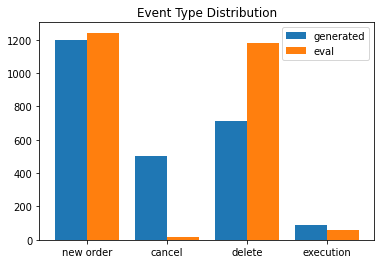

In [166]:
plot_order_type_frequency(results['event_types_gen'], results['event_types_eval'])

Text(0.5, 1.0, 'Inter-Arrival Time Distribution')

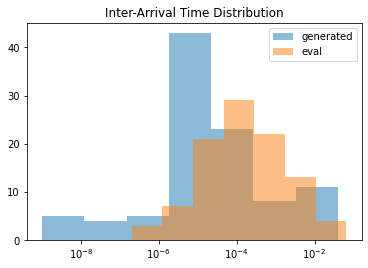

In [ ]:
plot_log_hist(delta_t_gen.flatten(), label='generated')
plot_log_hist(delta_t_eval.flatten(), label='eval')
plt.title('Inter-Arrival Time Distribution')

Text(0.5, 1.0, 'Inter-Arrival Time Distribution')

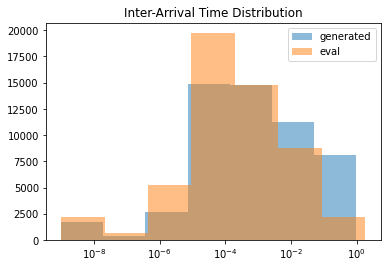

In [24]:
plot_log_hist(results['delta_t_gen'].flatten(), label='generated')
plot_log_hist(results['delta_t_eval'].flatten(), label='eval')
plt.title('Inter-Arrival Time Distribution')

In [25]:
results['delta_t_eval'].flatten().shape

(53600,)

In [26]:
results['delta_t_gen'].flatten().shape

(53600,)

In [153]:
eval.emp_cdf(results['delta_t_gen'].flatten())

(Array([9.9999997e-10, 9.9999997e-10, 9.9999997e-10, ..., 9.6202385e-01,
        9.7234219e-01, 9.8603922e-01], dtype=float32),
 Array([1.8656716e-05, 3.7313432e-05, 5.5970148e-05, ..., 9.9996269e-01,
        9.9998134e-01, 1.0000000e+00], dtype=float32))

In [154]:
eval.prob_plot_2samples(
    results['delta_t_gen'].flatten(),
    results['delta_t_eval'].flatten()
)

Text(0.5, 1.0, 'QQ-Plot of Inter-Arrival Time Distribution')

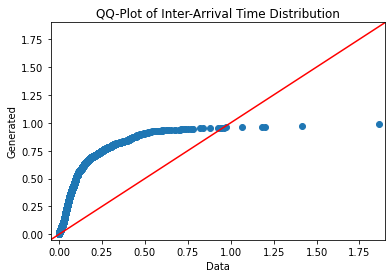

In [155]:
# not that useful due to long tail of the distribution
# --> we see here mostly the tail in the plot which doesn't match well
#     but has only a small number of samples

from statsmodels.graphics.gofplots import qqplot_2samples

_ = qqplot_2samples(
    results['delta_t_eval'].flatten(),
    results['delta_t_gen'].flatten(),
    xlabel='Data',
    ylabel='Generated',
    line='45'
)
plt.title('QQ-Plot of Inter-Arrival Time Distribution')

Text(0, 0.5, 'Wasserstein distance')

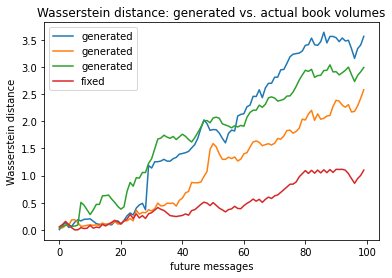

In [46]:
# single data sample

plt.plot(
    onp.arange(book_loss_wass_j.shape[1]),
    book_loss_wass_j.T,
    label='generated'
)
plt.plot(
    book_loss_wass_const,
    label='fixed'
)
plt.legend()
plt.title('Wasserstein distance: generated vs. actual book volumes')
plt.xlabel('future messages')
plt.ylabel('Wasserstein distance')

In [ ]:
# note: don't make mistake of comparing MEAN generated returns to realised returns

In [44]:
results['num_errors']

Array([[ 11],
       [ 34],
       [ 20],
       [ 14],
       [ 12],
       [ 24],
       [ 26],
       [ 49],
       [ 22],
       [ 12],
       [ 37],
       [ 13],
       [ 32],
       [ 10],
       [ 16],
       [ 28],
       [ 17],
       [ 27],
       [ 18],
       [ 13],
       [ 20],
       [ 20],
       [ 12],
       [ 14],
       [ 41],
       [ 33],
       [ 27],
       [ 11],
       [ 36],
       [  7],
       [ 20],
       [ 12],
       [ 24],
       [ 12],
       [ 32],
       [ 55],
       [ 14],
       [ 26],
       [ 18],
       [ 23],
       [ 29],
       [ 11],
       [ 34],
       [ 15],
       [ 20],
       [ 11],
       [ 30],
       [ 22],
       [ 15],
       [ 35],
       [ 28],
       [ 14],
       [ 23],
       [ 59],
       [ 23],
       [ 38],
       [ 50],
       [ 20],
       [ 23],
       [ 15],
       [ 23],
       [ 18],
       [ 10],
       [ 11],
       [ 34],
       [112],
       [ 13],
       [ 17],
       [ 24],
       [ 17],
       [ 16],
      

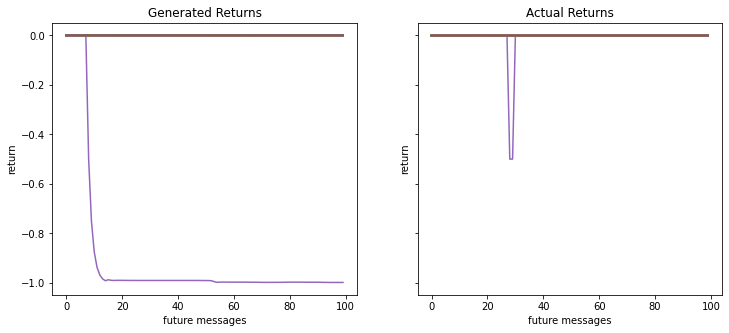

In [28]:
plot_returns(results['rets_gen'], results['rets_eval'])

In [21]:
# remove one outlier path

results['rets_gen'] = jnp.delete(results['rets_gen'], 184, axis=0)
results['rets_eval'] = jnp.delete(results['rets_eval'], 184, axis=0)

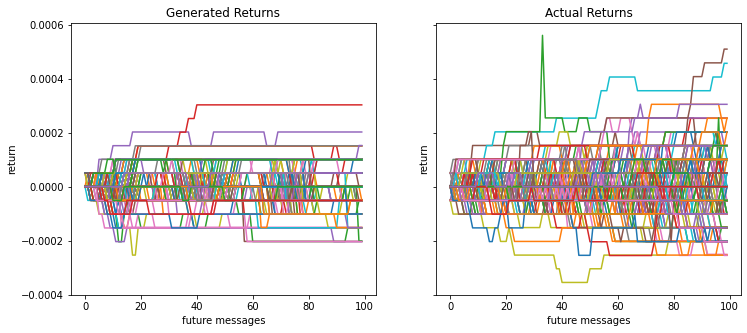

In [160]:
eval.plot_returns(results['rets_gen'], results['rets_eval'])

In [162]:
eval.plot_ret_corr

<function lob.evaluation.plot_ret_corr(rets_gen, rets_eval, ci=None, rng=None)>

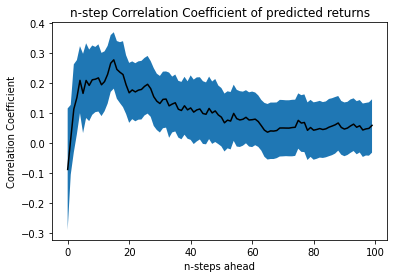

In [164]:
rng, rng_ = jax.random.split(rng)
eval.plot_ret_corr(results['rets_gen'], results['rets_eval'], ci=0.95, rng=rng_)

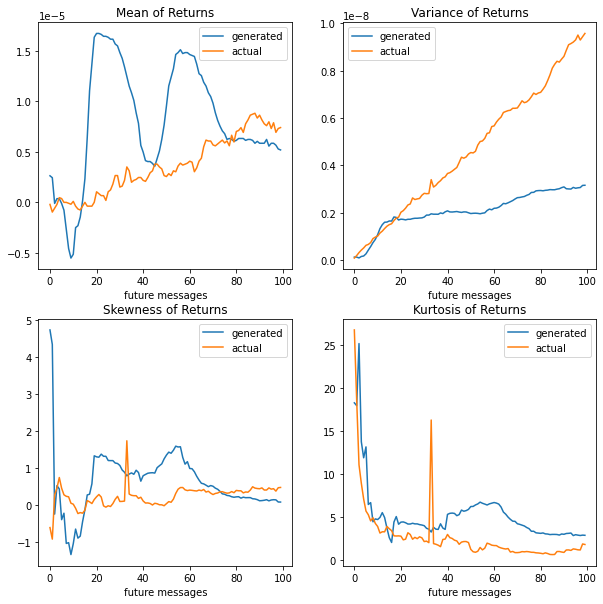

In [165]:
r_gen_mean, r_gen_var, r_gen_skew, r_gen_kurt = eval.calc_moments(results['rets_gen'])
r_eval_mean, r_eval_var, r_eval_skew, r_eval_kurt = eval.calc_moments(results['rets_eval'])

eval.plot_moments(
    r_gen_mean, r_gen_var, r_gen_skew, r_gen_kurt,
    r_eval_mean, r_eval_var, r_eval_skew, r_eval_kurt)

In [85]:
plt.plot(r_gen_mean, label='generated')
plt.plot(r_eval_mean, label='actual')
plt.title('Mean of Returns')
plt.xlabel('future messages')
plt.legend()

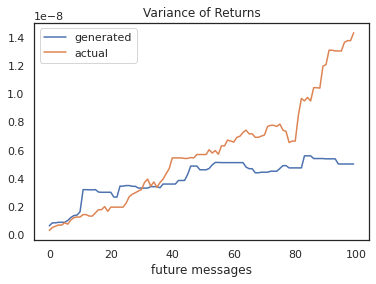

In [86]:
plt.plot(r_gen_var, label='generated')
plt.plot(r_eval_var, label='actual')
plt.title('Variance of Returns')
plt.xlabel('future messages')
plt.legend()

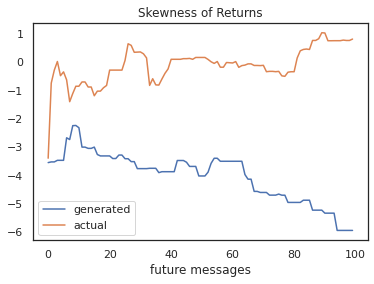

In [87]:
plt.plot(r_gen_skew, label='generated')
plt.plot(r_eval_skew, label='actual')
plt.title('Skewness of Returns')
plt.xlabel('future messages')
plt.legend()

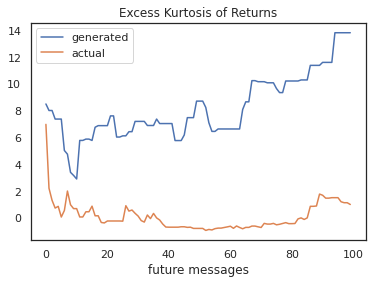

In [88]:
plt.plot(r_gen_kurt, label='generated')
plt.plot(r_eval_kurt, label='actual')
plt.title('Excess Kurtosis of Returns')
plt.xlabel('future messages')
plt.legend()

In [89]:
# TODO: plot this for multiple samples

_ = plt.plot(rets_eval.T, linestyle='--', label='actual')
# reset color cycle
plt.gca().set_prop_cycle(None)
_ = plt.plot(rets_gen.T, label='generated')
plt.legend()

Text(0, 0.5, 'Correlation Coefficient')

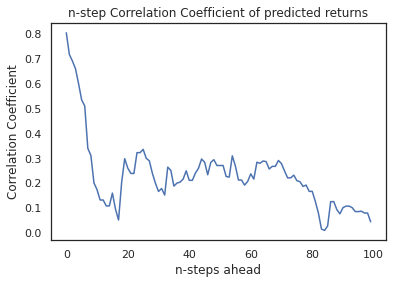

In [93]:
ret_corr = eval.return_corr(rets_gen, rets_eval)
plt.plot(ret_corr)
plt.title('n-step Correlation Coefficient of predicted returns')
plt.xlabel('n-steps ahead')
plt.ylabel('Correlation Coefficient')

In [ ]:
#mid_price_loss_l1(l2_book_states, l2_book_states_eval)

Array([0. , 0. , 0. , 0. , 1. , 1. , 1.5, 1.5, 2.5, 2.5, 2.5, 3. , 3.5,
       3.5, 3.5, 3.5, 4. , 4. , 4. , 4. , 4. , 4.5, 4.5, 4.5, 5. , 5. ,
       5. , 4.5, 4. , 4. , 4. , 4. , 4. , 4. , 4. , 4. , 4. , 4. , 4. ,
       4. , 4. , 4. , 4. , 4. , 4.5, 5.5, 5.5, 5.5, 5.5, 5.5, 5.5, 5.5,
       5.5, 5.5, 5.5, 4. , 4. , 4. , 4. , 4. , 4. , 4. , 4. , 4. , 4. ,
       4. , 4. , 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 5. ,
       5. , 5. , 5. , 5. , 5. , 5. , 5. , 5. , 5. , 5. , 5. , 5. , 6. ,
       6. , 6. , 6. , 5.5, 5.5, 5.5, 5.5, 5.5, 5.5],      dtype=float32, weak_type=True)

Text(0, 0.5, 'mean abs. loss')

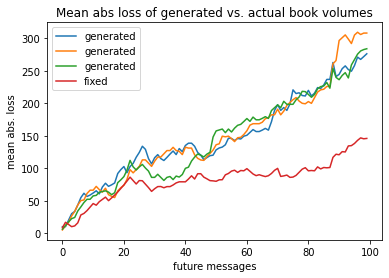

In [24]:
# single data sample

plt.plot(
    onp.arange(book_loss_l1_j.shape[1]),
    book_loss_l1_j.T,
    label='generated'
)
plt.plot(
    book_losses_l1_const.mean(axis=0),
    label='fixed'
)
plt.legend()
plt.title('Mean abs loss of generated vs. actual book volumes')
plt.xlabel('future messages')
plt.ylabel('mean abs. loss')

Text(0, 0.5, 'mean abs. loss')

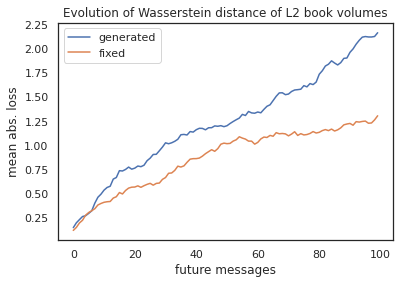

In [104]:
plt.plot(
    book_losses_wass.mean(axis=(0,1)),
    label='generated'
)
plt.plot(
    book_losses_wass_const.mean(axis=0),
    label='fixed'
)
plt.legend()
plt.title('Evolution of Wasserstein distance of L2 book volumes')
plt.xlabel('future messages')
plt.ylabel('mean abs. loss')

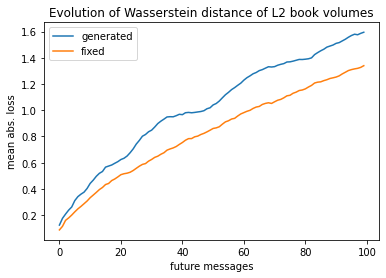

In [166]:
eval.plot_book_losses(
    results['book_losses_wass'],
    results['book_losses_wass_const'],
    'Wasserstein'
)

Text(0, 0.5, 'mean abs. loss')

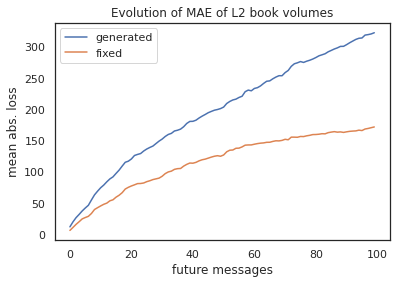

In [105]:
plt.plot(
    book_losses_l1.mean(axis=(0,1)),
    label='generated'
)
plt.plot(
    book_losses_l1_const.mean(axis=0),
    label='fixed'
)
plt.legend()
plt.title('Evolution of MAE of L2 book volumes')
plt.xlabel('future messages')
plt.ylabel('mean abs. loss')

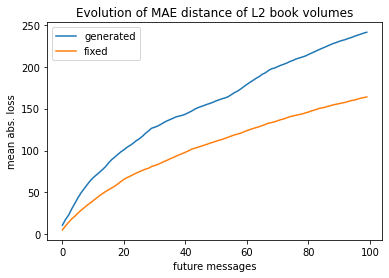

In [167]:
eval.plot_book_losses(
    results['book_losses_l1'],
    results['book_losses_l1_const'],
    'MAE'
)

Text(0, 0.5, 'Squared Error')

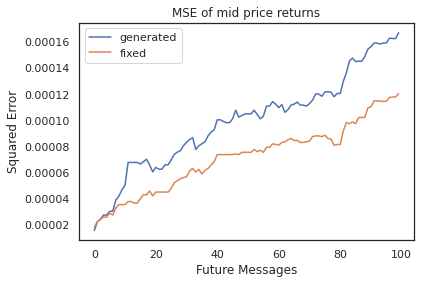

In [106]:
plt.plot(
    jnp.sqrt(mid_ret_errs.mean(axis=0)),
    label='generated'
)
plt.plot(
    jnp.sqrt(mid_ret_errs_const.mean(axis=0)),
    label='fixed'
)
plt.legend()
plt.title('MSE of mid price returns')
plt.xlabel('Future Messages')
plt.ylabel('Squared Error')

In [64]:
jnp.square(results['rets_gen'] - results['rets_eval']).mean(axis=0)

(535, 100)

Text(0, 0.5, 'Squared Error')

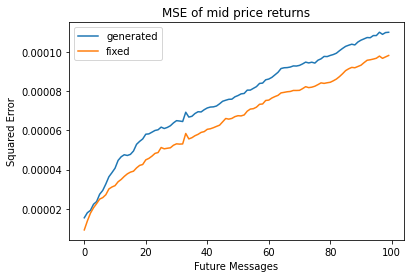

In [168]:
# removed one outlier

plt.plot(
    jnp.sqrt(jnp.square(results['rets_gen'] - results['rets_eval']).mean(axis=0)),
    label='generated'
)
plt.plot(
    jnp.sqrt(jnp.square(results['rets_eval']).mean(axis=0)),
    label='fixed'
)
plt.legend()
plt.title('MSE of mid price returns')
plt.xlabel('Future Messages')
plt.ylabel('Squared Error')

In [169]:
# outlier in data

mid_ret_errs = eval.mid_price_ret_squ_err(
    results['mid_gen'], results['mid_eval'], mid_t0)
# compare to squared error from const prediction
mid_ret_errs_const = jnp.square(rets_eval)

eval.plot_return_mse(
    mid_ret_errs,
    mid_ret_errs_const
)

KeyError: 'mid_gen'

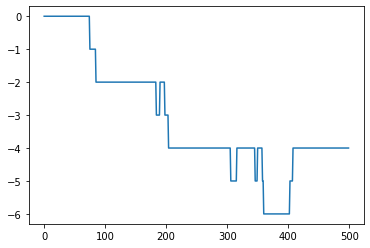

In [65]:
# price drift in sequence
plt.plot(onp.cumsum(b_seq[:, 0]))

In [107]:
def plot_l2_book(i_book, ax, xlim=None, ylim=None):
    i, book = i_book
    book = onp.array(book.reshape((-1, 2)))
    book[::2, 1] = book[::2, 1] * -1
    book = book[book[:, 0] != -1]

    ax.clear()
    plt.title("L2 Book: " + ticker + " - " + data_date + " - " + start_time_dt.strftime("%H:%M:%S"))
    plt.xlabel("Volume")
    plt.ylabel("Price")
    # option 2, remove all lines and collections
    # for artist in ax.lines + ax.collections:
    #     artist.remove()
    time_text = ax.text(
        0.05, 0.95, '#state: ' + str(i),
        horizontalalignment='left',verticalalignment='top',
        transform=ax.transAxes
    )
    
    bars = ax.barh(book[:, 0], book[:, 1], height=90, color='b')
    
    #xlim = ax.get_xlim()
    #x_abs_max = onp.max(onp.abs(xlim))
    #ax.set_xlim(-x_abs_max, x_abs_max)

    ylim = ax.get_ylim()
    p_mid = (book[0, 0] + book[1, 0]) / 2
    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is None:
        y_half_range = onp.max((ylim[1] - p_mid, p_mid - ylim[0]))
        ax.set_ylim(p_mid + y_half_range, p_mid - y_half_range)
    else:
        ax.set_ylim(ylim)

    return bars

<BarContainer object of 19 artists>

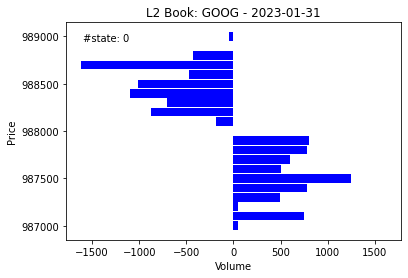

In [91]:
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111)
plt.title("L2 Book: " + ticker + " - " + data_date)
plt.xlabel("Volume")
plt.ylabel("Price")
max_vol = int(1.1 * onp.max(l2_book_states.reshape(l2_book_states.shape[0], -1, 2)[:, :, 1]))
xlim = (-max_vol, max_vol)

plot_l2_book((0, l2_book_states[1]), ax, xlim=xlim)

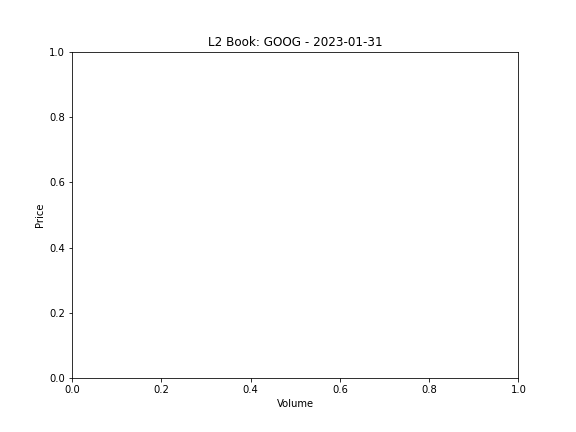

In [115]:
%matplotlib ipympl

import matplotlib.animation

max_vol = int(1.1 * onp.max(l2_book_states.reshape(l2_book_states.shape[0], -1, 2)[:, :, 1]))
xlim = (-max_vol, max_vol)

fig = plt.figure(figsize=[8, 6])
ax = fig.add_subplot(111)
plt.title("L2 Book: " + ticker + " - " + data_date)
plt.xlabel("Volume")
plt.ylabel("Price")

ani = matplotlib.animation.FuncAnimation(
    fig,
    lambda b: plot_l2_book(b, ax, xlim=xlim),
    frames=list(enumerate(l2_book_states)),
    interval=200,
    repeat_delay=1000,
    #blit=True,
)
#plt.tight_layout()
plt.show()
ani.save(
    '../tmp/animation.webp',
    writer='imagemagick',
    fps=5,
    savefig_kwargs=dict(facecolor='#EAEAF2')
)

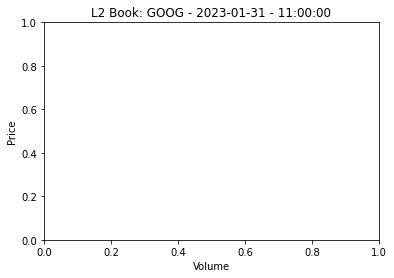

In [130]:
#pause
ani.event_source.stop()

#unpause
#ani.event_source.start()

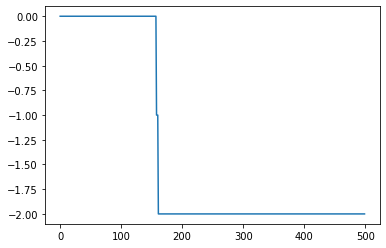

In [150]:
%matplotlib inline

# price drift in sequence
plt.plot(onp.cumsum(b_seq[:, 0]))

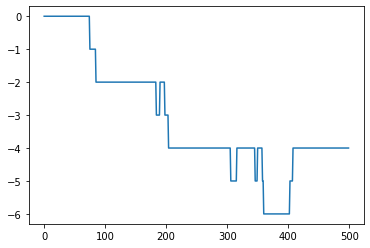

In [120]:
%matplotlib inline

# inspect movement of best bid price for sequence including
# generated flow at the end

# price drift in sequence
plt.plot(onp.cumsum(b_seq[:, 0]))

In [156]:
%matplotlib inline

l = Message_Tokenizer.MSG_LEN
decod_gen_msgs = tok.decode(m_seq.reshape((-1,l))[-100:], v)
decod_gen_msgs = pd.DataFrame(decod_gen_msgs, columns=Message_Tokenizer.FIELDS)
decod_gen_msgs

time  event_type   size  price  direction      time_new  \
0   5.399342e+12         1.0  100.0   -1.0        1.0           NaN   
1   5.399282e+12         1.0  100.0   -2.0        1.0  5.399342e+12   
2   5.399350e+12         1.0  100.0    1.0        0.0           NaN   
3   5.399282e+12         1.0  100.0   -2.0        1.0  5.399350e+12   
4   5.399257e+12         1.0  200.0   -1.0        1.0  5.399350e+12   
..           ...         ...    ...    ...        ...           ...   
95  5.399304e+12         1.0  600.0    4.0        0.0  5.399347e+12   
96  5.399299e+12         1.0  100.0   -1.0        1.0           NaN   
97  5.399334e+12         1.0   50.0   -7.0        1.0  5.399298e+12   
98  5.398295e+12         1.0  306.0   -8.0        1.0           NaN   
99  5.399338e+12         1.0  100.0   -2.0        1.0  5.398295e+12   

    event_type_new  size_new  price_new  direction_new  
0              NaN       NaN        NaN            NaN  
1              3.0     100.0       -1.0            1.0  
2              NaN       NaN        NaN            NaN  
3              3.0     100.0       -1.0            1.0  
4              2.0     100.0       -1.0            1.0  
..             ...       ...        ...            ...  
95             2.0      51.0        6.0            0.0  
96             NaN       NaN        NaN            NaN  
97             3.0      50.0       -7.0            1.0  
98             NaN       NaN        NaN            NaN  
99             3.0     100.0       -2.0            1.0  

[100 rows x 10 columns]

In [160]:
%matplotlib inline
decod_gen_msgs['size'].value_counts().sort_index()

3.0       1
21.0      1
25.0      1
50.0     13
51.0     10
61.0      3
100.0    53
200.0    11
300.0     2
306.0     3
600.0     2
Name: size, dtype: int64

<AxesSubplot:>

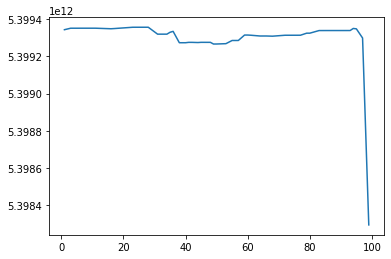

In [161]:
%matplotlib inline

# arriving mod times should be monotonically increasing...
decod_gen_msgs.dropna(subset=['time_new']).time_new.plot()

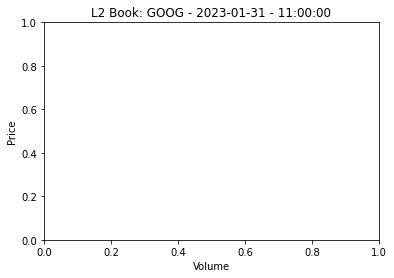

In [162]:
# new orders
new_orders = decod_gen_msgs.loc[decod_gen_msgs.time_new.isna()]

0     5.399342e+12
2     5.399350e+12
12    5.399350e+12
13    5.399346e+12
14    5.399346e+12
15    5.399348e+12
18    5.399372e+12
19    5.399354e+12
20    5.399355e+12
21    5.399355e+12
22    5.399355e+12
29    5.399313e+12
30    5.399317e+12
33    5.399318e+12
37    5.399256e+12
43    5.399273e+12
46    5.399271e+12
51    5.399265e+12
52    5.399265e+12
54    5.399256e+12
58    5.401286e+12
62    5.399311e+12
63    5.399308e+12
65    5.399309e+12
67    5.399309e+12
69    5.399308e+12
70    5.399312e+12
71    5.399312e+12
78    5.399324e+12
81    5.399338e+12
82    5.399338e+12
86    5.399338e+12
92    5.399338e+12
96    5.399299e+12
98    5.398295e+12
Name: time, dtype: float64

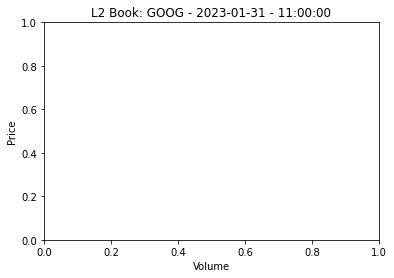

In [163]:
new_orders.time

<AxesSubplot:title={'center':'L2 Book: GOOG - 2023-01-31 - 11:00:00'}, xlabel='Volume', ylabel='Price'>

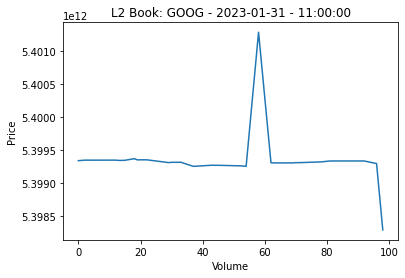

In [164]:
# error: should be monotonically increasing
new_orders.time.plot()

In [74]:
new_orders.event_type.value_counts()

1.0    65
Name: event_type, dtype: int64

In [75]:
# only order modifications
modif_orders = decod_gen_msgs.dropna()

In [76]:
modif_orders.event_type_new.value_counts()

3.0    22
2.0     9
4.0     2
Name: event_type_new, dtype: int64

### Model Validation (optional)

In [ ]:
dataset_obj = LOBSTER(
    'lobster',
    #data_dir='/nfs/home/peern/LOBS5/data/',
    data_dir='/nfs/home/peern/LOBS5/data/new_enc/',
    mask_fn=LOBSTER_Dataset.causal_mask,
    use_book_data=True,
    book_transform=True,
    msg_seq_len=500,
    n_cache_files=100,
)
dataset_obj.setup()

In [ ]:
test_loader = make_data_loader(
    dataset_obj.dataset_test,
    dataset_obj,
    seed=args.jax_seed,
    batch_size=args.bsz,
    drop_last=True,
    shuffle=False,
    num_workers=0
)

In [26]:
rng = jax.random.PRNGKey(42)
tok = Message_Tokenizer()

all_pred_toks = []
all_labels = []

losses = []
accuracy = []
ranks = []
valid_mass = []
valid_mass_n5 = []
valid_pred = []
losses_baseline = []

VALID_MATRIX = valh.syntax_validation_matrix()

for batch_idx, batch in enumerate(tqdm(test_loader)):
    
    # PREPARE BATCH
    inputs, labels, integration_timesteps = prep_batch(batch, seq_len, n_classes, num_devices=1)
    # INFERENCE STEP
    loss, acc, pred = eval_step(
        inputs, labels, integration_timesteps, par_state, model.apply, args.batchnorm)

    loss = loss.squeeze(axis=0)
    acc = acc.squeeze(axis=0)
    pred = pred.squeeze(axis=0)
    
    # STORE RESULTS
    pred_toks = pred.argmax(axis=-1)
    all_labels += labels.tolist()
    all_pred_toks += pred_toks.tolist()
    
    # STATS
    losses.append(cross_entropy_loss(pred, labels))
    accuracy.append(compute_accuracy(pred, labels))
    
    # where does the correct label rank in the predicted distribution?
    ranks.append(valh.pred_rank(pred, labels))
    # how much of the predicted distribution is valid?
    masked_fields = valh.get_masked_fields(batch[0])
    valid_mass.append(valh.valid_prediction_mass(pred, masked_fields))
    valid_mass_n5.append(valh.valid_prediction_mass(pred, masked_fields, top_n=5))

    # check if argmax prediction is valid token for masked fields
    valid_pred.append(valh.is_tok_valid(pred_toks, masked_fields, v))

    # benchmark: uniform prediction over syntactically valid tokens
    pos = valh.get_masked_idx(batch[0])[..., -1]
    baseline_distr = VALID_MATRIX[pos] / VALID_MATRIX[pos].sum(axis=-1, keepdims=True)
    losses_baseline.append(cross_entropy_loss(jnp.log(
            jnp.where(baseline_distr==0, 1e-10, baseline_distr)
        ), labels)
    )

all_labels = jnp.array(all_labels)
all_pred_toks = jnp.array(all_pred_toks)
losses = jnp.array(losses)
accuracy = jnp.array(accuracy)
ranks = jnp.array(ranks)
valid_mass = jnp.array(valid_mass)
valid_mass_n5 = jnp.array(valid_mass_n5)
valid_pred = jnp.array(valid_pred)
losses_baseline = jnp.array(losses_baseline)

NameError: name 'test_loader' is not defined

In [ ]:
print('mean loss', losses.mean())
print('mean accuracy', accuracy.mean())
print('mean rank', ranks.mean())
print('median rank', onp.median(ranks))
print('mean valid mass', valid_mass.mean())
print('mean valid mass (top 5)', valid_mass_n5.mean())
print('mean valid prediction', valid_pred.mean())
print('mean baseline loss (uniform over valid syntax)', losses_baseline.mean())

mean loss 1.4749558
mean accuracy 0.688901
mean rank 72.28813
median rank 0.0
mean valid mass 0.971541
mean valid mass (top 5) 0.9579046
mean valid prediction 0.98988515
mean baseline loss (uniform over valid syntax) 5.2721515


In [ ]:
from sklearn.metrics import precision_recall_fscore_support
import numpy as onp
import pandas as pd


precision, recall, fscore, support = precision_recall_fscore_support(
    all_labels.astype(int),
    all_pred_toks,
    labels=range(len(v)),
    zero_division=0,
    average=None
)

'''
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))
'''

"\nprint('precision: {}'.format(precision))\nprint('recall: {}'.format(recall))\nprint('fscore: {}'.format(fscore))\nprint('support: {}'.format(support))\n"

In [ ]:
field_dec = onp.array([(field, dec) for tok, (field, dec) in sorted(v.DECODING_GLOBAL.items())])

scores_df = pd.DataFrame({
    'field': field_dec[:, 0],
    'decoded': field_dec[:, 1],
    'precision': precision,
    'recall': recall,
    'fscore': fscore,
    'support': support,
})
#scores_df

In [ ]:
# left to right causal prediction:

scores_df.loc[scores_df.support > 0].groupby('field').agg(
    precision=('precision', 'mean'),
    recall=('recall', 'mean'),
    fscore=('fscore', 'mean'),
    support=('support', 'sum'),
)

precision    recall    fscore  support
field                                             
direction    0.624236  0.632841  0.626838      436
event_type   0.393960  0.399946  0.396617      465
generic      1.000000  0.998603  0.999301      716
price        0.557158  0.452684  0.477146      676
size         0.213366  0.152106  0.170773      680
time         0.011118  0.037804  0.016177      685